<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/1_Introduction_basicEDA_Duolingo_spaced_repetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

Duolingo is a popular ed-tech company that gamifies language learning. It has a freemium business model, so increasing student engagement is vital. 

As part of its plan for increasing student engagement, Duolingo predicts how well a student might have retained the meanings and usage of words, and constructs a model of student’s understanding to produce targeted practice sessions that review words before are forgotten, and maximize retention (see below image). These indicators allows learners to better plan their study time, encouraging better retention, and therefore increasing motivation to continue using Duolingo.  

**ADD image here**
<figcaption align = "left"><b>Fig.1 -Duolingo strength meter</b></figcaption>

This series of notebooks is the code for a capstone project in predicting how well a student has remembered a word to fill in the strength meters for every word the student has learned, based on a replication dataset published by B. Settles and B. Meeder. 2016. [A Trainable Spaced Repetition Model for Language Learning](https://github.com/duolingo/halflife-regression/blob/master/settles.acl16.pdf). In _Proceedings of the Association for Computational Linguistics (ACL)_, pages 1848-1858.

In my capstone, using the dataset provided, the following questions are explored:

<font color='cornflowerblue' size=1>
Q1) What makes words difficult or easy for a student to remember?</font>

In addition to the sparse lexeme tags provided in the dataset, a number of word-based features are considered, such as the IDF of the word in English, the lexical similarity of the word in the language being learned, and the learner's native language, and word embeddings.

Classical machine learning techniques such as logistic regression, SVM, kNN, decision trees, ensemble techniques such as random forests, XGBoost, and finally, neural nets are trained and compared.

The test set for Q1 consists of words not seen in the training data. 

<font color='cornflowerblue' size=1>
Q2) What learning habits increase a student's retention?
</font>

Although the dataset only spans a short time, student performance as a function of time is encoded in daily average features in a manner similar to a time series, and added to the best model of Q1 to see how prediction performance improves. 

The test set for Q2 consists of students not seen in the training data. 

<font color='cornflowerblue' size=1>
Q3) The cold-start problem: Duolingo is always adding new language courses, might good predictions based on learnings from Q1 and Q2 be possible for a NEW LANGUAGE?
</font> 

The best model from Q2 is tested on two new languages courses unseen by the model.

The dataset spans 14 days of students learning second languages through Duolingo’s gamified system and has 12.8 million records and 12 variables.

**Feature sets:**

How well a word is retained depends on the word itself, and the student’s individual learning pace and capacity. The following features were provided in the dataset. 

**_Interaction features:_**
includes total number of times a student has seen the word $x_n$, the number of times it was correctly recalled, the number of times incorrectly recalled. 

**_Lexeme tag features:_** meant to capture the inherent difficulty of each particular word.

In the dataset, the lexeme string has a format like below: 
```"surface form/lemma<pos><modifiers>"```

For instance ```
hombre/hombre<n><m><sg>``` - where hombre ('man' in Spanish) has a lemmatized form 'hombre', is a noun (```<n>```), and has modifier tags ```<m>``` and ```<sg>```

Link for dataset download:
https://paperswithcode.com/dataset/duolingo-spaced-repetition-data

Data dictionary: 

-   `p_recall` - proportion of exercises from this lesson/practice where the word/lexeme was correctly recalled
-   `timestamp` - UNIX timestamp of the current lesson/practice
-   `delta` - time (in seconds) since the last lesson/practice that included this word/lexeme
-   `user_id` - student user ID who did the lesson/practice (anonymized)
-   `learning_language` - language being learned
-   `ui_language` - user interface language (presumably native to the student)
-   `lexeme_id` - system ID for the lexeme tag (i.e., word)
-   `lexeme_string` - lexeme tag (see below)
-   `history_seen` - total times user has seen the word/lexeme prior to this lesson/practice
-   `history_correct` - total times user has been correct for the word/lexeme prior to this lesson/practice
-   `session_seen` - times the user saw the word/lexeme during this lesson/practice
-   `session_correct` - times the user got the word/lexeme correct during this lesson/practice

Here $p\_recall = \frac{session\ correct}{session\ seen}$

In the rest of this notebook, we will clean the downloaded dataset, and do some preliminary EDA to understand the breadth and depth of the data. 

The dataset was downloaded to my Google drive, and is now copied to the notebook. 

In [184]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileid = "1MdLRV3GQ76-xqSGkH1QUDQ1MHrg_JtU_"
filename = "settles.acl16.learning_traces.13m.csv.gz"

# download the file to notebook
downloaded = drive.CreateFile({'id':fileid}) 
downloaded.GetContentFile(filename)

The file is unzipped to get a csv file, and data processing libraries are imported below. 

In [185]:
# from https://www.tutorialspoint.com/python-support-for-gzip-files-gzip
import gzip
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
datacsv = []
with gzip.open("settles.acl16.learning_traces.13m.csv.gz", 'rb') as f_in:
  with open("settles.acl16.learning_traces.13m.csv", 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

Reading into a dataframe

In [186]:
datadf = pd.read_csv("settles.acl16.learning_traces.13m.csv")

### <font color='cornflowerblue' size = 3>Basic EDA</font>

Dimensions of the dataset:

In [187]:
datadf.shape

(12854226, 12)

The size of the dataframe in memory:

In [188]:
print(f"Size of dataframe: {datadf.size/10**6} MB")

Size of dataframe: 154.250712 MB


There are 12.85 million records and 12 columns, taking up 154.2 MB of memory. 

The first few records are displayed below: 

In [189]:
datadf.head(4)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1


It appears that each record is for one user learning one word, with the history of that word for that user, and particulars of language, and the number of questions for that word in that session.

From looking at the first few values of timestamp (all the same values), it probably marks the beginning of a learning session where each word learned in that session is listed in a separate record. 

Getting more information on the contents:

In [190]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.1+ GB


The columns are listed on basis of datatype in the table below:

| Categorical       	| Numerical         	| Time based 	|
|-------------------	|-------------------	|------------	|
| lexeme_id         	| p_recall (target) 	| Timestamp  	|
| lexeme_tag        	| history_correct   	| delta      	|
| learning_language 	| history_seen      	|            	|
| ui_language       	| session_correct   	|            	|
| user_id           	| session_seen      	|            	|

Basic descriptive statistics for the numerical columns are below:

In [191]:
datadf.describe().T

,count,mean,std,min,25%,50%,75%,max
p_recall,12854226.0,8.961056e-01,2.714048e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
timestamp,12854226.0,1.362589e+09,2.932082e+05,1.362076e+09,1.362343e+09,1.362591e+09,1.362846e+09,1.363105e+09
delta,12854226.0,7.295811e+05,2.246499e+06,1.000000e+00,5.320000e+02,7.713400e+04,4.425070e+05,4.032836e+07
history_seen,12854226.0,2.198109e+01,1.295508e+02,1.000000e+00,3.000000e+00,6.000000e+00,1.500000e+01,1.351800e+04
history_correct,12854226.0,1.935025e+01,1.119681e+02,1.000000e+00,3.000000e+00,6.000000e+00,1.300000e+01,1.288800e+04
session_seen,12854226.0,1.817686e+00,1.360180e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+01
session_correct,12854226.0,1.644134e+00,1.318794e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+01


From count, there are no null values in the numerical columns. The min and max values show no strange, improbable values. 

Checking for null values:

In [192]:
datadf.isna().any()

p_recall             False
timestamp            False
delta                False
user_id              False
learning_language    False
ui_language          False
lexeme_id            False
lexeme_string        False
history_seen         False
history_correct      False
session_seen         False
session_correct      False
dtype: bool

There are no null values. 

Checking for duplicates:

In [193]:
datadf[datadf.duplicated()]

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
3067848,0.75,1362334650,6037137,u:fyCE,es,en,86584daef5933b284384453795bbf0ed,hombre/hombre<n><m><sg>,4,3,4,3
3067849,0.80,1362334650,6037137,u:fyCE,es,en,605a1c36da2cf22706eaad95b0b7eeee,niño/niño<n><m><sg>,3,3,5,4
3402349,0.50,1362353111,426085,u:zD_,fr,en,c5059c4d9d73f25a415904bade8a1337,posé/poser<vblex><pp><m><sg><@compound_past>,25,12,2,1
3402354,0.00,1362353111,3906547,u:zD_,fr,en,22ba409694ae64f3768d993f4b81708f,parliez/parler<vblex><pii><p2><pl>,1,1,1,0
3402355,1.00,1362353111,435992,u:zD_,fr,en,c4d97966fdca70e0964004f50ff50d66,entièrement/entièrement<adv>,20,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7702861,1.00,1362683117,82,u:i5X3,en,es,c52ab45d4e22ee7580041911159e3c0c,water/water<n><sg>,5,4,1,1
7722347,1.00,1362684186,331356,u:gMHD,en,es,1849080c74cfc80bb39a5a493e85efe8,see/see<vblex><inf>,17,15,1,1
7722348,0.00,1362684186,330165,u:gMHD,en,es,019e69c0c7349a49fff531b7c5fc263c,have/have<vbhaver><pres><@present_perfect>,73,66,1,0
7722349,0.00,1362684186,77803,u:gMHD,en,es,e09b138d58a98c83f120ffbc898ce818,at/at<pr>,61,54,1,0


There are 81 duplicate rows. 

Deleting duplicate rows:

In [194]:
datadf = datadf.drop_duplicates()

In [195]:
datadf.shape

(12854145, 12)

A quick look at the distributions of numerical and time based columns:

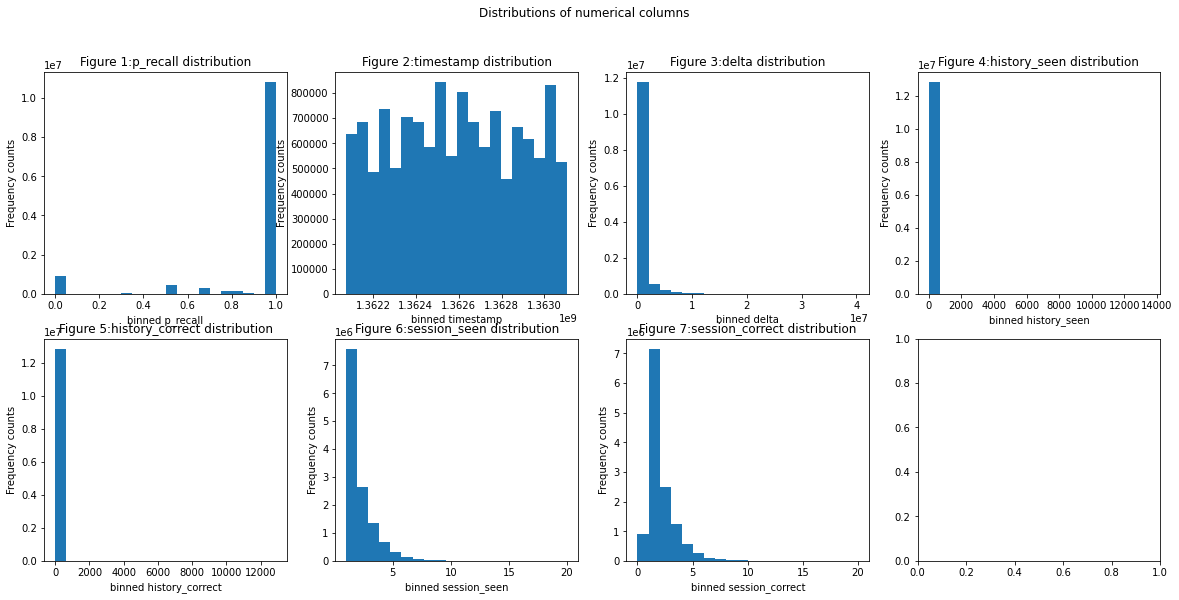

In [196]:
plt.subplots(2,4,figsize = (20,9))
plt.suptitle("Distributions of numerical columns")
plot_num = 1
for col in datadf.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(2,4,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(datadf[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

**Observations**: 
1. From Figure 1, we see that in the overwhelming majority of p_recall = 1, meaning that the word was perfectly retained. This is a **highly imbalanced dataset**.
2. Timestamp (Figure 2) is fairly uniformly distributed - meaning that there are close to the same number of records for each day.  
3. Figure 3 shows that delta is skewed heavily to the right, with most values being close to zero.
4. Figures 4 and 5 (history seen and history correct) are heavily skewed to the right. Most values are low, showing that many new words are being learned. 
5. Figures 6 and 7 (session seen and session correct) show that the number of times a word is encountered in a session is typically ~ 1. 

Basic information on the categorical columns is obtained using the wrapper function defined below:

In [197]:
def categorical_describe(df_cat): # function to take in the df containing categrical columns 
    # and return information in a dataframe format for display

  datatype = dict()
  most_common = dict()
  most_common_frac = dict()
  num_unique = dict()
  num_null_vals = dict()
  num_empty_vals = dict()

  for col in df_cat.columns: # go through each column 
    datatype[col] = type(df_cat[col].head(1).values[0]) # get datatype
    
    # get the most frequent value and its corresponding percentage counts in column
    top_val = df_cat[col].value_counts(normalize=True).sort_values(ascending=False).head(1) 
    most_common[col] = top_val.index[0]
    most_common_frac[col] = top_val.values[0]
    
    # get number of unique values
    num_unique[col] = len(df_cat[col].unique())
    
    # get number of null values
    num_null_vals[col] = df_cat[col].isna().sum()
    
    # get number of empty strings
    # strip spaces and then count characters- if 0, then it is 'empty string'
    if datatype[col]==str:
        num_empty_vals[col] = df_cat[col].apply(lambda x: len(x.rstrip().lstrip())==0).sum() 
    else:
        num_empty_vals[col] = 0

  return pd.DataFrame({'datatype':pd.Series(datatype), 'most_common':pd.Series(most_common),
                       'most_common_fraction':pd.Series(most_common_frac),
                       'number_unique_values': pd.Series(num_unique),
                       'number_null_values':pd.Series(num_null_vals),
                      'number_empty_vals': pd.Series(num_empty_vals)})
  


In [198]:
df_cat = datadf.select_dtypes(include=['object']) # creating view of dataframe with categoricals only

In [199]:
categorical_describe(df_cat)

,datatype,most_common,most_common_fraction,number_unique_values,number_null_values,number_empty_vals
user_id,<class 'str'>,u:bcH_,0.001493,115222,0,0
learning_language,<class 'str'>,en,0.390129,6,0,0
ui_language,<class 'str'>,en,0.609871,4,0,0
lexeme_id,<class 'str'>,827a8ecb89f9b59ac5c29b620a5d3ed6,0.009577,19279,0,0
lexeme_string,<class 'str'>,a/a<det><ind><sg>,0.009577,18781,0,0


**Observations**:

1. There are 115,222 unique users in the dataset. 
2. There are 6 learning languages, and 4 native languages in the dataset. 
3. English makes up 39% of the languages being learned, and 61% of the native language of learners. 
4. There are 19,279 individual lexeme_ids, but only 18,781 lexeme strings. This might be because there are words that are common to more than one language and therefore have the same lexeme string. Of these, the lexeme ```"a"``` is the most commonly encountered one, making up almost 1% of the dataset. 
5. There are no null or empty string values. 


### <font color = 'cornflowerblue' size=3>Target variable analysis and transformation:</font>

Previously, it was seen that the distribution of recall probability was highly imbalanced. The histogram is reproduced below:

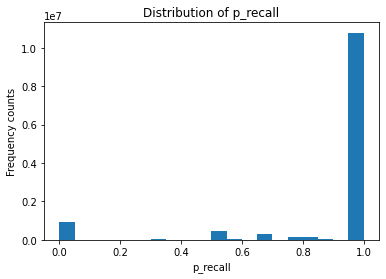

In [ ]:
plt.figure()
plt.title("Distribution of p_recall")
plt.xlabel("p_recall")
plt.ylabel("Frequency counts")
plt.hist(datadf['p_recall'],bins=20)
plt.show()

The values of p_recall are discretely distributed because they are computed from session correct and session_seen columns, which in turn are integers. 

p_recall is being calculated as the fraction of the number of questions in the session related to that word answered correctly. 

Plotting the distribution of p_recall as a function of session_seen:

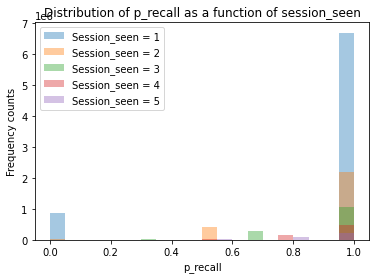

In [ ]:
plt.figure()
plt.title("Distribution of p_recall as a function of session_seen")
plt.xlabel("p_recall")
plt.ylabel("Frequency counts")
for n in range(1,6): # this range is chosen since the most common bracket of session_seen values was between 1-5. 
  plt.hist(datadf.loc[datadf['session_seen']==n,'p_recall'],bins=20,label=f"Session_seen = {n}",alpha=0.4)
plt.legend()
plt.show()

There is an interesting relationship between the distribution of recall probability, and the number of questions seen in the session related to a word. 

For a session_seen = 1, the recall probability has only 2 values: 0 and 1.

For session_seen = 2, p_recall is almost never zero, and is either 0.5 (or $\frac{1}{2}$) or 1. 

For session_seen = 3, p_recall is almost never zero, and is either 0.66 (or $\frac{2}{3}$) or 1.

For session_seen = 4, p_recall is almost never zero, and is either 0.75 (or $\frac{3}{4}$) or 1.

For session_seen = 5, p_recall is almost never zero, and is either 0.80 (or $\frac{4}{5}$) or 1.

<font color = 'cornflowerblue' size=0.9>
As a Duolingo user myself, I know that if I answer a question incorrectly, feedback in the form of the correct answer is provided immediately. Effectively, delta (duration between word encounters) is set to 0 the moment feedback is provided.</font>


It appears that students are able to retain the immediate feedback, and answer all but one questions of a word they had forgotten, correctly. 

The target variable is therefore transformed so that if a single question is answered incorrectly, it is assumed to have been forgotten. 

$p\_forgot = 1 - p\_recall$<br>
$p\_forgot\_bin = 1\ if\ p\_forgot\ >\ 0,\ otherwise\ 0$<br>


In [ ]:
# transforming target variable
datadf['p_forgot'] = 1 - datadf['p_recall']
datadf['p_forgot_bin'] = np.where(datadf['p_forgot']>0,1,0) # conservative approach - if p_forgot is not zero, it must be 1. 

Distribution of tranformed target variable:

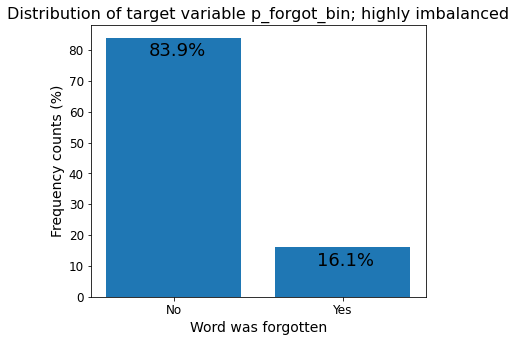

In [ ]:
counts = np.around(datadf['p_forgot_bin'].value_counts(normalize=True)*100,2)
plt.figure(figsize=(6,5))
plt.bar(counts.index,counts)
plt.xticks([0,1],fontsize=12,labels = ['No','Yes'])
plt.yticks(fontsize=12)
plt.ylabel("Frequency counts (%)",fontsize=14)
plt.xlabel("Word was forgotten",fontsize=14)
plt.title("Distribution of target variable p_forgot_bin; highly imbalanced",fontsize=16)
plt.annotate("83.9%",(0-.15,78),fontsize=18,c='black')
plt.annotate("16.1%",(1-.15,10),fontsize=18,c='black')
plt.show()

In spite of the conservative approach of marking a word as forgotten if even one question was answered incorrectly in the session, there are only 16.1% records where a word is forgotten. As a binary classification problem, the dataset is **imbalanced**. 

This might be because Duolingo (at the time this dataset was collected), was **underpredicting retention**, and assuming students have forgotten words when they have not, making students practice words they already know many times over.  

A more accurate model will help to reduce boredom in students (and increase engagement) by pinpointing only words that are truly forgotten. For a metric for classification model performance and comparison, **average precision** will be used, and prioritized over perfect recall. 


### <font color = 'cornflowerblue' size=3>Language courses offered:</font>

To look at the language courses being offered, learning language and native language are cross-tabulated below:

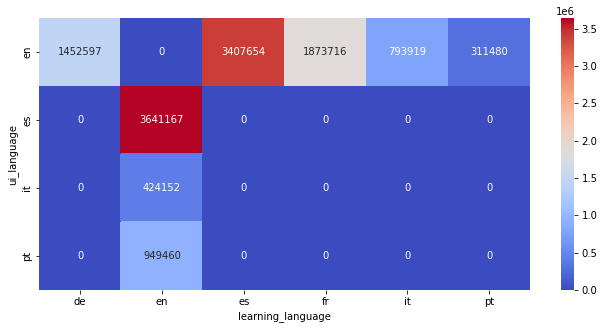

In [233]:
ctable = pd.crosstab(datadf['ui_language'],datadf['learning_language'])
# INSERT HERE add a mask for zero values. 
plt.figure(figsize=(11,5))
sns.heatmap(ctable,cmap="coolwarm",annot=True,fmt='d')
plt.show()

The numbers in the table above show the number of records for each course. 

The dataset has Spanish, Italian and Portugese speaking students learning English.

English speaking students are learning German, Spanish, Italian, Portugese, and French.

There are no odd values like learning language and native language being the same.

#### Unique words in each language

In [201]:
 # count of number of unique words in each learning language
numwords_perlang = datadf.groupby('learning_language')['lexeme_id'].unique().apply(len).sort_values(ascending=False)

In [202]:
numwords_perlang

learning_language
fr    4184
de    3809
es    3302
en    2983
pt    2815
it    2186
Name: lexeme_id, dtype: int64

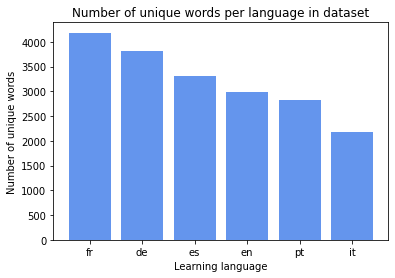

In [203]:
# plotting bar chart of number of unique words per language. 
plt.figure()
plt.bar(numwords_perlang.index,numwords_perlang,color='cornflowerblue')
plt.title("Number of unique words per language in dataset")
plt.xlabel("Learning language")
plt.ylabel("Number of unique words")
plt.show()

The dataset has 4184 unique French words being learned, followed by 3809 German words, and 3302 Spanish words. 

###<font color = 'cornflowerblue' size=3>Lexical similarity: Are languages with more shared vocabulary with English easier to learn?</font>

Previously, it was seen that there were more unique values of lexeme_id than lexeme_string, (in other words, not a one-to-one mapping). This is possibly because of words that are common to two or more languages, having unique ids, but the same lexeme strings. 

Listing the lexeme_string values with more than one language below:

In [204]:
# getting number of languages for each lexeme string
lexeme_numlanguages = datadf.groupby('lexeme_string')['learning_language'].unique().apply(len).sort_values(ascending=False) 

# counting the number of lexeme strings with more than one language
lexeme_numlanguages[lexeme_numlanguages>1].shape[0]

462

There are 462 words that are common to two or more languages in the dataset. 

This leads to a **hypothesis that if native and learning languages have words in common, those words are highly likely to be remembered correctly.**

In later notebooks, string distance measures are investigated as potential predictors of recall probability. 

A rough value of lexical similarity (how similar the vocabularies of two languages are) might also be computed from the pandas series above. It might partially explain the inherent difficulty of learning a language A while being a language B speaker. 

In the code block below, a ratio of common words and different words in each language pair is calculated. 

In [205]:
# For each pair of languages, the number of words that are common to them.

similar_over_different = dict()

# list of learning languages
learnlang_list = datadf['learning_language'].unique()

for (L1,L2) in itertools.combinations(learnlang_list, 2): # iterating over every pair of learning languages
  # set of lexeme strings in L1
  L1strings = set(datadf.loc[datadf['learning_language']==L1,'lexeme_string'])
  # set of lexeme strings in L1
  L2strings = set(datadf.loc[datadf['learning_language']==L2,'lexeme_string'])
  # compute the number of common words between Languages L1 and L2
  commonwords =  L1strings.intersection(L2strings)
  num_commonwords = len(commonwords)

  # number of words only in 1 of the languages 
  not_in_commonwords = L1strings.symmetric_difference(L2strings)
  num_not_in_commonwords = len(not_in_commonwords)

  # computing and saving lexical similarity to dictionary
  similar_over_different[(L1,L2)] = num_commonwords/num_not_in_commonwords


In [240]:
similar_over_different = pd.DataFrame(similar_over_different)
similar_over_different.columns = ['Similar_over_different']
similar_over_different.sort_values(by='Similar_over_different',ascending=False)

,,Similar_over_different
es,pt,0.046649
pt,it,0.022571
es,it,0.012706
pt,fr,0.004614
es,fr,0.004447
fr,it,0.003160
de,fr,0.000752
en,it,0.000581
es,en,0.000159
de,pt,0.000151


Spanish, Italian and Portuguese share a significant number of words. French to a lesser extent shares words with the Latin languages. On the other hand, English and French share no words, nor do Portuguese and English, German and Spanish and German and Italian. 

This is aligned with computations of lexical similarity as seen in the table reproduced below from [wikipedia](https://en.wikipedia.org/wiki/Lexical_similarity)

In [207]:
lexical_simwiki = pd.DataFrame([[1,0.27,0.6,None,None,None],\
                                [0.27,1,0.29,0.89,0.75,0.75],\
                                [0.6,0.29,1,None,None,None],\
                                [None,0.89,None,1,None, 0.82],\
                                [None,0.75,None,None,1,0.89],\
                                [None,0.75,None,0.82,0.89,1]],index= ['English','French','German','Italian','Portuguese','Spanish'],columns = ['English','French','German','Italian','Portuguese','Spanish'])

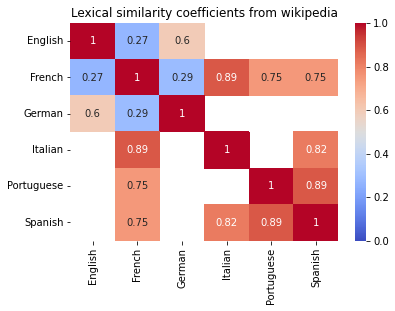

In [208]:
plt.figure()
plt.title("Lexical similarity coefficients from wikipedia")
sns.heatmap(lexical_simwiki,cmap="coolwarm",vmin=0,vmax=1,annot=True)
plt.show()

An image from graphical analysis of lexical similarity is below: 

INSERT HERE. 

The relative percentage of records with forgotten words is plotted by learning language below:

<Figure size 864x432 with 0 Axes>

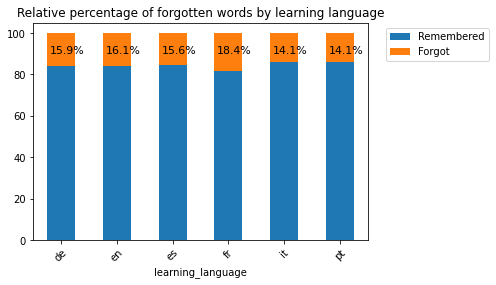

p_forgot_bin,0,1
learning_language,,
de,84.1,15.9
en,83.9,16.1
es,84.4,15.6
fr,81.6,18.4
it,85.9,14.1
pt,85.9,14.1


In [231]:
# Tabulating the WNV test results across the different mosquito species. 
ctable = pd.crosstab(datadf['learning_language'],datadf['p_forgot_bin']).apply(lambda x:x/sum(x)*100,axis = 1)

#display(HTML('<b>Relative percentage of WNV positive mosquito samples by species'))
plt.figure(figsize=(12,6))
ctable.plot(kind ='bar',stacked=True)
plt.title('Relative percentage of forgotten words by learning language')
plt.legend(bbox_to_anchor=(1.04,1),labels = ['Remembered','Forgot'])
plt.xticks(rotation = 45)

for i,ind in enumerate(ctable.index):
  plt.annotate(str(ctable.loc[ind,1].round(1))+"%",(i-0.2,90),fontsize=11,c='black')
plt.show()

#display(HTML('<b>Relative percentage of WNV positive mosquito samples by species'))
display(ctable.round(1))

French with a lexical similarity of 0.27 with English has a higher percentage of forgotten words compared to German, which has a lexical similarity of 0.6 with English. 

For the **cold-start problem** with new languages, the above analysis might be useful. 

### <font color='cornflowerblue' size=3>Transforming time variables:</font>

Converting timestamp to a datetime object:

In [241]:
# converting timestamp to datetime object
from datetime import datetime
datadf['Datetime'] = datadf['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
datadf['Datetime'].head()

0   2013-02-28 18:28:01
1   2013-02-28 18:28:01
2   2013-02-28 18:28:01
3   2013-02-28 18:28:01
4   2013-02-28 18:28:01
Name: Datetime, dtype: datetime64[ns]

In [242]:
datadf['Datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                12854145
unique                 574814
top       2013-03-05 21:09:36
freq                      217
first     2013-02-28 18:28:01
last      2013-03-12 16:14:57
Name: Datetime, dtype: object

The dataset spans 13 days from 28 Feb, 2013 to 12 Mar, 2013. 

The distribution of delta in the histograms above show that there are a large number of low values. Looking at the counts of the 15 lowest values of delta.

In [247]:
datadf['delta'].value_counts().sort_index(ascending=True).head(15)

1     664
2     424
3     282
4     151
5      49
6      67
7      20
8      95
9     157
10     56
11    231
12    279
13    331
14    277
15    258
Name: delta, dtype: int64

There are surprosingly records with delta as low as 1 - 15 seconds! No wonder the dataset is imbalanced. One would expect that differing results in two session records <=15 seconds apart is more a function of the student either not paying focused attention or not understanding the concept, rather than an effect of memory.  

Transforming delta to days for visualization:

In [264]:
datadf['delta_days'] = datadf['delta']/60/60/24

# How many records have delta < 1 day?
datadf[datadf['delta_days']<1].shape[0]/datadf.shape[0]*100

52.97252364898638

The percentage of records that have delta < 1 day (reviewed on the same day) is 53%. This might also partially explain why the target variable p_forgot_bin is so heavily skewed towards remembering words perfectly.

### <font color = 'cornflowerblue' size = 3>How does time since last review impact probability of forgetting a word?</font>

One would expect that forgotten words would on average have been reviewed a longer time ago. 

Delta is in seconds, and so is transformed to days for easier visualization:

In [243]:
datadf['delta_days'] = datadf['delta']/60/60/24

In [244]:
# How many records have delta < 1 day?
datadf[datadf['delta_days']<1].shape[0]/datadf.shape[0]*100

52.97252364898638

The percentage of records that have delta < 1 day (reviewed on the same day) is 53%. This might also partially explain why the target variable p_forgot_bin is so heavily skewed. 

The distributions for delta in days for forgotten words and remembered words is plotted below: (blue is remembered words, orange is forgotten)

(0.0, 100.0)

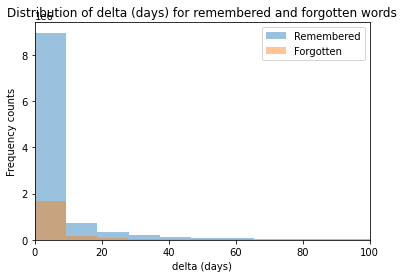

In [245]:
plt.figure()
plt.hist(datadf.loc[datadf['p_forgot_bin']==0,'delta_days'],bins=50,label="Remembered",alpha=0.45)
plt.hist(datadf.loc[datadf['p_forgot_bin']==1,'delta_days'],bins=50,label="Forgotten",alpha=0.45)
plt.legend()
plt.xlabel("delta (days)")
plt.ylabel("Frequency counts")
plt.title("Distribution of delta (days) for remembered and forgotten words")
plt.xlim((0,100))

The shapes of the distributions are similar: skewed to the right. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


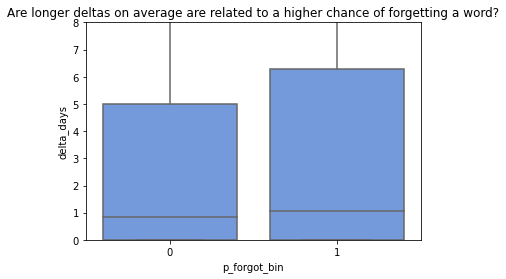

In [219]:
plt.figure()
plt.title("Are longer deltas related to a higher chance of forgetting a word?")
sns.boxplot(datadf['p_forgot_bin'],datadf['delta_days'],color='cornflowerblue')
plt.ylim((0,8))
plt.show()

At a glance, there is not much difference in the mean values of delta for forgotten words and remembered words. There is a great deal of overlap. 

Since delta is not normally distributed for either group, Kruskal-Wallis test is used to check if the two groups are significantly different. 
**INSERT HERE**
Assumptions:

Null hypothesis:
Alternate hypothesis: 

In [220]:
from scipy import stats
stats.kruskal(datadf.loc[datadf['p_forgot_bin']==0,'delta_days'], datadf.loc[datadf['p_forgot_bin']==1,'delta_days'])

KruskalResult(statistic=26094.40170342701, pvalue=0.0)

Another way of visualizing the effect of delta is the fraction of words forgotten for binned intervals of delta_days. 

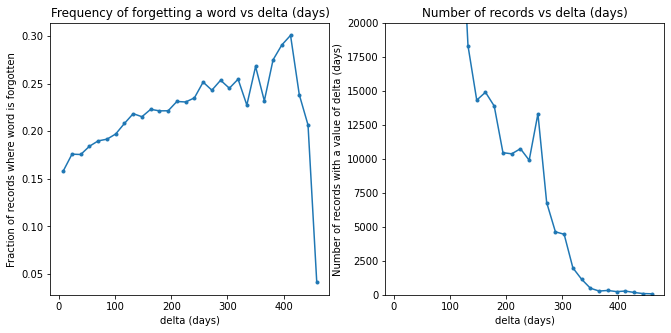

In [232]:
# binning values of delta
datadf['binned_deltadays'] = pd.cut(datadf['delta_days'],30)

# for each bin of delta, gettin the percentage of records with words forgotten
meanp_delta = datadf.groupby('binned_deltadays').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_delta = meanp_delta.reset_index()
# getting the middle value of each bin interval
meanp_delta['binned_deltadays_mid'] = meanp_delta['binned_deltadays'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(11,5))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_delta['binned_deltadays_mid'],meanp_delta['fraction_forgotten'],'.-')
plt.xlabel("delta (days)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs delta (days)")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_delta['binned_deltadays_mid'],meanp_delta['totalcount'],'.-')
plt.xlabel("delta (days)")
plt.ylabel("Number of records with a value of delta (days)")
plt.ylim(0,20000)
plt.title("Number of records vs delta (days)")
plt.show()

plt.show()

- In the lineplot above, the fraction of forgotten words steadily increases with delta, as might be expected. However, there is a sharp drop at around 400 days. when the total count of records is reduced to < 200. For the majority of the records, probability of forgetting increases with delta.

At extremely low deltas (1-15 seconds), the mean probability of 'forgetting' is calculated below:

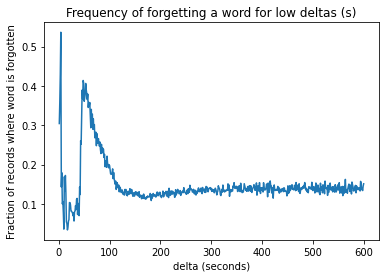

In [258]:
meanp_lowdelta = datadf.loc[datadf['delta']<=600,['delta','p_forgot_bin']].groupby('delta')['p_forgot_bin'].mean()
plt.figure()
plt.xlabel("delta (seconds)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word for low deltas (s)")
plt.axvline(x=120,color='black',linestyle='--')
plt.plot(meanp_lowdelta.index,meanp_lowdelta)
plt.show()

The above plot is interesting and might be capturing real-time memory transfer phenomena. At very low delta values (0-50 seconds), probability of forgetting is quite low, possibly because the learned information is still in the learner's working memory. 

As the learner continues to learn other words, at some point the word might leave working memory and be transferred to long term memory with some initial probability of recalling it. 

There is then a period where probability of forgetting actually decreases, which is an interesting phenomenon. 

Past around 120 seconds, probability of forgetting slowly increases with increasing delta. 

The span of delta is huge (1 second to > 400 days). 



In [261]:
print("The percentage of records with delta < 15 minutes: ")
np.around(datadf.loc[datadf['delta']<900,:].shape[0]/datadf.shape[0]*100,1)

The percentage of records with delta < 15 minutes: 


30.9

A whopping 31 % of records have delta < 15 minutes.

If students are checking the retention strength meters as they are deciding what to study next, and are looking for a high retention reading to be satisfied that they have practiced a word enough, the model needs to account for the lower deltas as well as longer deltas. 

### <font color = "cornflowerblue" size=2>How does a learner's history with a word impact probability of forgetting a word?</font>

A box plot of history_seen vs p_forgot_bin is below:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


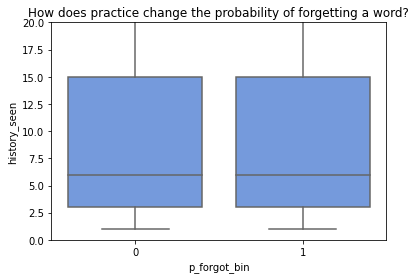

In [266]:
plt.figure()
plt.title("How does practice change the probability of forgetting a word?")
sns.boxplot(datadf['p_forgot_bin'],datadf['history_seen'],color='cornflowerblue')
plt.ylim((0,20))
plt.show()

There is virtually no difference between the mean value of history_seen for records with forgotten or remembered words. 

Since the distribution of history_seen is not normal (figure reproduced below), Kruskal-Wallis test is done

Null hypothesis
Alternate Hypothesis

**INSERT HERE**

In [267]:
stats.kruskal(datadf.loc[datadf['p_forgot_bin']==0,'history_seen'], datadf.loc[datadf['p_forgot_bin']==1,'history_seen'])

KruskalResult(statistic=101.7866889220487, pvalue=6.183426957396604e-24)

pvalue is << 0.05, indicating that the two groups have different means.

Looking at fraction of records with forgotten words for each interval of binned history_seen.

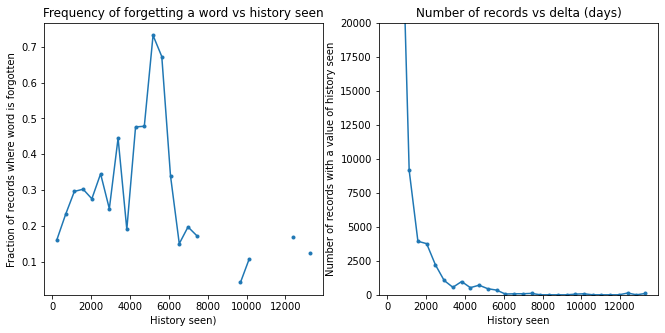

In [276]:
# binning values of delta
datadf['binned_hseen'] = pd.cut(datadf['history_seen'],30)

# for each bin of delta, gettin the percentage of records with words forgotten
meanp_hseen = datadf.groupby('binned_hseen').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_hseen = meanp_hseen.reset_index()
# getting the middle value of each bin interval
meanp_hseen['binned_hseen_mid'] = meanp_hseen['binned_hseen'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(11,5))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_hseen['binned_hseen_mid'],meanp_hseen['fraction_forgotten'],'.-')
plt.xlabel("History seen)")
#plt.xlim((0,4500))
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs history seen")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_hseen['binned_hseen_mid'],meanp_hseen['totalcount'],'.-')
plt.xlabel("History seen")
plt.ylabel("Number of records with a value of history seen")
plt.ylim(0,20000)
plt.title("Number of records vs delta (days)")
plt.show()

plt.show()

There is no clear relationship between history_seen and probability of forgetting a word. 

Exploring a derived feature:

$history\_frac = \frac{history\_correct}{history\_seen}$

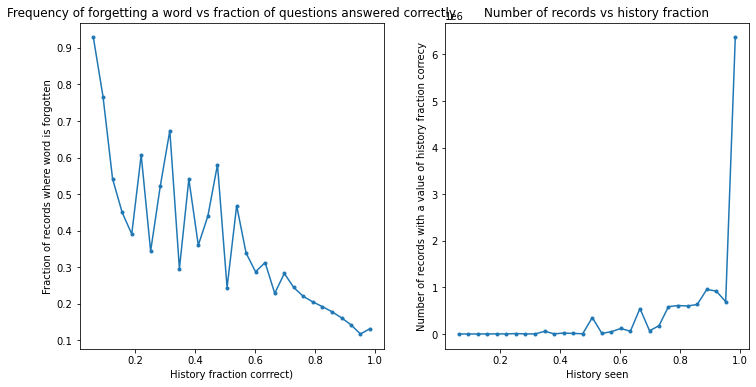

In [278]:
datadf['history_frac'] = datadf['history_correct']/datadf['history_seen']

datadf['binned_hfrac'] = pd.cut(datadf['history_frac'],30)

# for each bin of history fraction, getting the percentage of records with words forgotten
meanp_hfrac = datadf.groupby('binned_hfrac').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_hfrac = meanp_hfrac.reset_index()
# getting the middle value of each bin interval
meanp_hfrac['binned_hfrac_mid'] = meanp_hfrac['binned_hfrac'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(12,6))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_hfrac['binned_hfrac_mid'],meanp_hfrac['fraction_forgotten'],'.-')
plt.xlabel("History fraction corrrect)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs fraction of questions answered correctly")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_hfrac['binned_hfrac_mid'],meanp_hfrac['totalcount'],'.-')
plt.xlabel("History fraction correct")
plt.ylabel("Number of records with a value of history fraction correct")
plt.title("Number of records vs history fraction")
plt.show()

Fraction of records with forgotten words shows a rough downward trend with increasing fraction of previous correct answers in history. This would be expected - at lower fractions, when a word is new, the changes of forgetting it are higher than when it has been encountered a number of times.  


### <font color="cornflowerblue" size=2>Individual time traces</font>

Looking at the number of individual time traces with one learner practicing one word over the duration of the dataset. 

In [281]:
timetraces = datadf.groupby(['user_id','lexeme_id'])['timestamp'].count()
timetraces.head(10)

In [283]:
timetraces.shape[0]

5861629

There are 5.86 million timetraces, with a number of traces with just one record. 

In [286]:
timetraces[timetraces<=2].shape[0]/timetraces.shape[0]*100

76.0229110371878

Around 76% of the dataset is traces with just 2 or fewer records. This means that we don't have endless data

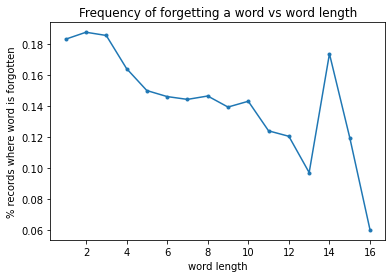

In [ ]:
plt.figure()
plt.plot(meanp_sflen.index,meanp_sflen,'.-')
plt.xlabel("word length")
plt.ylabel("% records where word is forgotten")
plt.title("Frequency of forgetting a word vs word length")
plt.show()

In [ ]:
datadf['history_frac'] = datadf['history_correct']/datadf['history_seen']

In [ ]:
sns.boxplot(datadf['p_forgot_bin'],datadf['history_frac'])

In [ ]:
datadf['history_seen'].median()

6.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


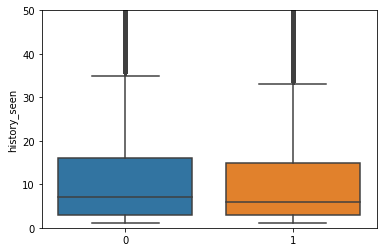

In [ ]:
sns.boxplot(np.where(datadf['p_recall']>0.5,1,0),datadf['history_seen'])
plt.ylim((0,50))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


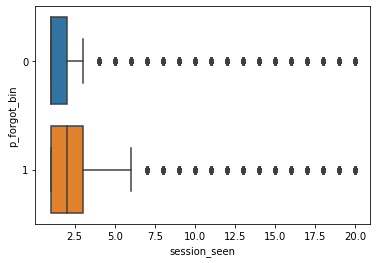

In [ ]:
sns.boxplot(datadf['session_seen'],datadf['p_forgot_bin'],orient='h')

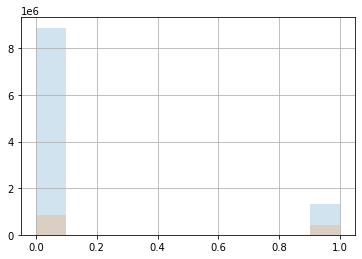

In [ ]:
datadf.loc[datadf['session_seen']<3,'p_forgot_bin'].hist(alpha=0.2)
datadf.loc[datadf['session_seen']>3,'p_forgot_bin'].hist(alpha=0.2)

p_recall is being calculated by the number of questions in the session answered correctly, as is p_forgot. There are two potential issues with this:

1. The first time the student encounters a question, if they answer it wrong, they get immediate feedback on the correct answer. The delta for subsequent questions then cannot accurately be considered the same as the first question. 
2. Distribution of p_recall depends on the number of questions answered. If the student answers 1 question on the word in the session, I have a lower confidence of it not being a co-incidence than if they answered more questions correctly.
 - we could consider the threshold for converting to a binary target variable to depend on the number of questions answered. 
 - we could ignore the single trace records, or model them separately.

The p_recall is stored as a float with 4 decimal sig figs. We probably don't need this level of differentiation, so we can change it to be correct to two decimal digits. (Possibly 1)


p_recall is rounded to two digits, and a distribution is tabulated. This is quite slow. 

In [ ]:
datadf.loc[datadf['delta']<24*60*60,:].shape[0]/datadf.shape[0]*100

52.972438791725

In [ ]:
run_slow = True

if run_slow:
  datadf['p_recall_trunc'] = np.around(datadf['p_recall'],2)
  p_distribution = pd.DataFrame(datadf['p_recall_trunc'].value_counts(normalize=True).sort_index(ascending=False))
  display(p_distribution.head(10))

,p_recall_trunc
1.00,0.838864
0.95,0.000012
0.94,0.000080
0.93,0.000103
0.92,0.000174
0.91,0.000172
0.90,0.000318
0.89,0.000501
0.88,0.000874
0.87,0.000026


Plotted below as histogram:

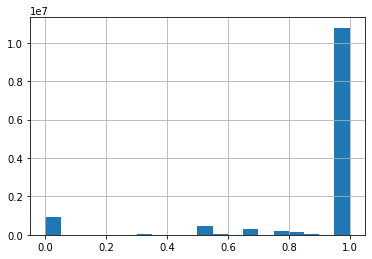

In [ ]:
datadf['p_recall_trunc'].hist(bins=20)

There are pockets between 0.5 to 0.85, but the overwhelming majority of the records show complete recall. We can assume that if a student remembers the word, they will answer the question correctly. We also assume that if they answered correctly, it is not becuase they got lucky with their guess. So all probabilities below one can be grouped as 'forgot', and p_recall = 1 can be 'hasn't forgotten'. We will compute p_forgot_bin (binary variable) as 1, if p_recall < 1.0, and 0 in all other cases. 

In [ ]:
datadf['p_forgot_bin'] = np.where(datadf['p_forgot']==0,0,1)

In [ ]:
datadf['p_forgot_bin'].value_counts(normalize=True)

0    0.838864
1    0.161136
Name: p_forgot_bin, dtype: float64

In [ ]:
datadf['delta_days'] = datadf['delta']/60/60/24

In [ ]:
datadf['delta_days'].head()

0    320.018924
1    320.018924
2    320.018924
3    320.018924
4    320.018924
Name: delta_days, dtype: float64

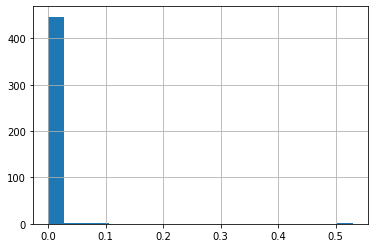

In [ ]:
datadf['delta_days'].astype(int).value_counts(normalize=True).hist(bins=20)

In [ ]:
datadf[datadf['delta_days'].astype(int)<1].shape[0]/datadf.shape[0]*100

52.972438791725

53% of the rows involve deltas from learning sessions less than 24 hours apart.


- we should look into whether the ones and zeros are mainly from single question sessions, and make a call on whether to use them for our predictions. If we use them, is it possible to evaluate models on their predictions on many-question sessions separately from single question sessions?

In [ ]:
datadf[datadf['session_seen']==1].shape[0]/datadf.shape[0]*100

58.93713864996617

59% of the records involve encountering a word only once in a session. 

Imbalanced dataset. will need to look into changing the weight of the classes, or up/down sampling. 

This is a highly imbalanced dataset. 


Let's get the number of student-word pairs that only show up once in the whole dataset.

The series tracelen stores the number of records linked to a unique student-word pairing. The number of student-word pairs with only one record is computed. 

In [ ]:
tracelen = datadf.groupby(['user_id','lexeme_id'])['p_forgot_bin'].count()

In [ ]:
tracelen[tracelen==1].shape[0]/tracelen.shape[0]*100

56.14807760777764

In [ ]:
tracelen[tracelen==1].shape[0]/datadf.shape[0]*100

25.603968687029464

Student word pairings with only one record in the 2 week dataset are 25% of the dataset. The distribution of # of records per student-word pair is below:

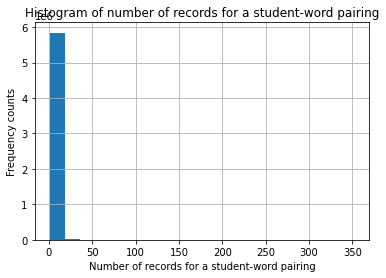

In [ ]:
plt.figure()
tracelen.hist(bins=20)
plt.xlabel("Number of records for a student-word pairing")
plt.ylabel("Frequency counts")
plt.title("Histogram of number of records for a student-word pairing")
plt.show()

Replotting on a log scale. 

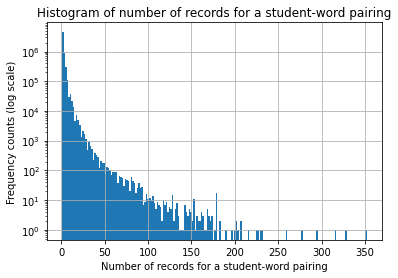

In [ ]:
plt.figure()
tracelen.hist(log=True,bins=200)
plt.xlabel("Number of records for a student-word pairing")
plt.ylabel("Frequency counts (log scale)")
plt.title("Histogram of number of records for a student-word pairing")
plt.show()

Although the majority of the student-word pairs have only one record or few records, there are a sizable # with more than 50 records in the two week span.

Can we cluster students based on profile? Can we use these clusters for predicting if they have forgotten a word or not?

1. Number of records.
2. number of languages learning actively
3. native language
4. learning language
5. average delta
8. std deviation of delta
9. average p_forgot_bin
10. average p_forgot
11. delta after lowest performance session?
12. delta of lowest performance session?
13. delta after highest performance session?
14. delta of highest performance session?
15. average # of sessions logged in per week
16. average words per session. 
17. average length of session

We can try to find learning sessions by clustering by timestamp using DBSCAN. 

splitting will have to take into account time series considerations - so if we are trying to predict, we should split by time, and also 


In [ ]:
datadf['p_recall'] = np.where(datadf['p_recall']==0,0.0001,datadf['p_recall']/(1.0001)) # modified to prevent log 0 errors in math below

In [ ]:
import math
import numpy as np

datadf['logp_recall'] = np.log2(datadf['p_recall'])


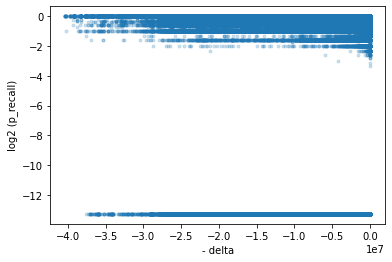

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(-datadf['delta'],datadf['logp_recall'],'.',alpha=0.2)
plt.xlabel("- delta")
plt.ylabel("log2 (p_recall)")

plt.show()

1/h would be the slope if h was constant. but it is not. so it is not linear. there are many h.

In [ ]:
# plotting the calculated h(t) from the experimental p_recall(t) vs # of exposures and deltas
import math
import numpy as np
#datadf['logp_recall_2'] = datadf['p_recall'].apply(lambda x: math.log(x,2))
#datadf['calc_h'] = - datadf['delta']/datadf['logp_recall_2']
trace = datadf.loc[(datadf['user_id']=='u:bcH_')&\
           (datadf['lexeme_string']=='my/my<det><pos><sp>'),:].\
           sort_values(by='Datetime',ascending=True)
trace.head()
# also getting an idea of the sensitivity of p to h.

KeyError: ignored

Get the dimensions of the dataset

In [ ]:
datadf.shape

(12854226, 14)

Check for duplicates

In [ ]:
# check for dupliacates?
datadf.duplicated().sum()

81

In [ ]:
datadf[datadf.duplicated()]

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,logp_recall_2,calc_h
3067848,0.749775,1362334650,6037137,u:fyCE,es,en,86584daef5933b284384453795bbf0ed,hombre/hombre<n><m><sg>,4,3,4,3,-0.415470,1.453085e+07
3067849,0.799760,1362334650,6037137,u:fyCE,es,en,605a1c36da2cf22706eaad95b0b7eeee,niño/niño<n><m><sg>,3,3,5,4,-0.322361,1.872788e+07
3402349,0.499850,1362353111,426085,u:zD_,fr,en,c5059c4d9d73f25a415904bade8a1337,posé/poser<vblex><pp><m><sg><@compound_past>,25,12,2,1,-1.000433,4.259007e+05
3402354,0.000100,1362353111,3906547,u:zD_,fr,en,22ba409694ae64f3768d993f4b81708f,parliez/parler<vblex><pii><p2><pl>,1,1,1,0,-13.287857,2.939938e+05
3402355,0.999700,1362353111,435992,u:zD_,fr,en,c4d97966fdca70e0964004f50ff50d66,entièrement/entièrement<adv>,20,11,1,1,-0.000433,1.007372e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702861,0.999700,1362683117,82,u:i5X3,en,es,c52ab45d4e22ee7580041911159e3c0c,water/water<n><sg>,5,4,1,1,-0.000433,1.894634e+05
7722347,0.999700,1362684186,331356,u:gMHD,en,es,1849080c74cfc80bb39a5a493e85efe8,see/see<vblex><inf>,17,15,1,1,-0.000433,7.656077e+08
7722348,0.000100,1362684186,330165,u:gMHD,en,es,019e69c0c7349a49fff531b7c5fc263c,have/have<vbhaver><pres><@present_perfect>,73,66,1,0,-13.287857,2.484712e+04
7722349,0.000100,1362684186,77803,u:gMHD,en,es,e09b138d58a98c83f120ffbc898ce818,at/at<pr>,61,54,1,0,-13.287857,5.855196e+03


In [ ]:
# unclear whether duplicated data, or just multiple times encountering the same word in thst session.
#datadf = datadf[~datadf.duplicated()]

only 81 records of duplicated data

In [ ]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
 12  logp_recall_2      float64
 13  calc_h             float64
dtypes: float64(3), int64(6), object(5)
memory usage: 1.3+ GB


In [ ]:
datadf.isna().any()

p_recall             False
timestamp            False
delta                False
user_id              False
learning_language    False
ui_language          False
lexeme_id            False
lexeme_string        False
history_seen         False
history_correct      False
session_seen         False
session_correct      False
logp_recall_2        False
calc_h               False
dtype: bool

In [ ]:
datadfcat = datadf.select_dtypes('object')

In [ ]:
datadfcat.columns

Index(['user_id', 'learning_language', 'ui_language', 'lexeme_id',
       'lexeme_string'],
      dtype='object')

In [ ]:
user_id_vals = datadfcat['user_id'].unique()
print(user_id_vals)

['u:FO' 'u:dDwF' 'u:g3WM' ... 'u:f_W4' 'u:i8m1' 'u:h8_Y']


In [ ]:
len(user_id_vals)

115222

there are 115,222 individual language learners in the dataset.

In [ ]:
uilang_vals = datadf['ui_language'].unique()

In [ ]:
print(len(uilang_vals),uilang_vals)

4 ['en' 'pt' 'es' 'it']


The dataset contains students whose first language is English, Portugese, Spanish and Italian.

In [ ]:
lelang_vals = datadf['learning_language'].unique()

In [ ]:
print(lelang_vals)

['de' 'es' 'pt' 'en' 'fr' 'it']


Languages being learned are German, Spanish, Portugese, English, French, and Italian. 

In [ ]:
pd.crosstab(datadf['ui_language'],datadf['learning_language'])

learning_language,de,en,es,fr,it,pt
ui_language,,,,,,
en,1452597,0,3407689,1873734,793935,311480
es,0,3641179,0,0,0,0
it,0,424152,0,0,0,0
pt,0,949460,0,0,0,0


The dataset has Spanish, Italian and Portugese students learning Englush, and English students learning German, Spanish, Italian, Portugese, French, and German. 
No odd values like learning language and native language being the same. We should confirm the meaning of ui_language and learning_language. 

In [ ]:
datadf['lexeme_id'].head(5)

0    76390c1350a8dac31186187e2fe1e178
1    7dfd7086f3671685e2cf1c1da72796d7
2    35a54c25a2cda8127343f6a82e6f6b7d
3    0cf63ffe3dda158bc3dbd55682b355ae
4    84920990d78044db53c1b012f5bf9ab5
Name: lexeme_id, dtype: object

In [ ]:
datadf['lexeme_string']

0           lernt/lernen<vblex><pri><p3><sg>
1              die/die<det><def><f><sg><nom>
2                   mann/mann<n><m><sg><nom>
3                   frau/frau<n><f><sg><nom>
4             das/das<det><def><nt><sg><nom>
                          ...               
12854221               the/the<det><def><sp>
12854222                eat/eat<vblex><pres>
12854223                  bread/bread<n><sg>
12854224            drink/drink<vblex><pres>
12854225                  water/water<n><sg>
Name: lexeme_string, Length: 12854226, dtype: object

In [ ]:
lexid_vals = datadf['lexeme_id'].unique()
print(len(lexid_vals))

19279


In [ ]:
lex_vals = datadf['lexeme_string'].unique()
print(len(lex_vals))

18781


Odd that it doesn't seem to be a one to one mapping between lexeme id and lexeme string. Must be a many to one mapping. 

In [ ]:
lexeme_lang = pd.crosstab(datadf['lexeme_id'],datadf['learning_language'])

In [ ]:
lexeme_lang_bool = lexeme_lang.astype(bool).sum(axis=1)
lexeme_lang_bool[lexeme_lang_bool!=1]

Series([], dtype: int64)

Lexeme id to language is a many to one mapping. How about lexeme string to language?

In [ ]:
lexs_lang = pd.crosstab(datadf['lexeme_string'],datadf['learning_language'])

In [ ]:
lexs_lang_bool = lexs_lang.astype(bool).sum(axis=1)
lexs_lang_bool[lexs_lang_bool!=1].sort_values(ascending=False)

lexeme_string
sentir/sentir<vblex><inf>                   3
carne/carne<n><f><sg>                       3
tu/tu<prn><tn><p2><mf><sg>                  3
<*sf>/sala<n><f><*numb>                     3
principalmente/principalmente<adv>          3
                                           ..
antes/antes<adv>                            2
andar/andar<vblex><inf><@future_phrasal>    2
anda/andar<vblex><pri><p3><sg>              2
amigos/amigo<n><m><pl>                      2
zoo/zoo<n><m><sg>                           2
Length: 462, dtype: int64

The above are the lexeme strings that are in more than one language. For instance, "sentir/\<vblex\>\<inf>\" is in 3 languages. We should see if lexeme strings that English has in common with other languages are answered correctly more often. Let's see which lexeme strings are in English and other languages.

In [ ]:
lexs_lang[(lexs_lang_bool!=1) & (lexs_lang['en']>1)]

learning_language,de,en,es,fr,it,pt
lexeme_string,,,,,,
also/also<adv>,16,1142,0,0,0,0
in/in<pr>,0,14102,0,0,345,0
no/no<adv>,0,13437,37234,0,2744,0
per/per<pr>,0,534,0,0,452,0


There are only 4 examples of lexemes that English shares with other languages. We should see if non-English speakers guess these correctly more often and vice versa.

How many students are learning more than one language at once?

In [ ]:
pd.crosstab(datadf['user_id'],datadf['learning_language']).astype(bool).sum(axis=1).sort_values(ascending=False).head(10)

user_id
u:cEsp    6
u:iv01    5
u:goSi    5
u:b5GM    5
u:hz37    5
u:iCe2    5
u:iRSg    5
u:iOwb    5
u:hnb-    5
u:cxnU    5
dtype: int64

In [ ]:
datadf.loc[datadf['user_id']=='u:cEsp','learning_language'].value_counts().index

Index(['en', 'it', 'pt', 'fr', 'es', 'de'], dtype='object')

There are some users who are learning multiple languages at the same time. 

In [ ]:
datadf['Datetime'] = pd.to_datetime(datadf['timestamp'])

In [ ]:
datadf['timestamp'].describe()

count    1.285423e+07
mean     1.362589e+09
std      2.932082e+05
min      1.362076e+09
25%      1.362343e+09
50%      1.362591e+09
75%      1.362846e+09
max      1.363105e+09
Name: timestamp, dtype: float64

In [ ]:
from datetime import datetime

# current date and time
now = datetime.now()

timestamp = datetime.timestamp(now)
print("timestamp =", timestamp)

timestamp = 1653450834.503986


In [ ]:
dt_object = datetime.fromtimestamp(timestamp)
dt_object

datetime.datetime(2022, 5, 25, 3, 53, 54, 503986)

In [ ]:
datadf['Datetime'] = datadf['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
datadf['Datetime'].head()

0   2013-02-28 18:28:01
1   2013-02-28 18:28:01
2   2013-02-28 18:28:01
3   2013-02-28 18:28:01
4   2013-02-28 18:28:01
Name: Datetime, dtype: datetime64[ns]

In [ ]:
datadf['Datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                12854226
unique                 574814
top       2013-03-05 21:09:36
freq                      217
first     2013-02-28 18:28:01
last      2013-03-12 16:14:57
Name: Datetime, dtype: object

In [ ]:
mintimestamp = datadf['timestamp'].min()
maxtimestamp = datadf['timestamp'].max()
print(datetime.fromtimestamp(mintimestamp))
print(datetime.fromtimestamp(maxtimestamp))

2013-02-28 18:28:01
2013-03-12 16:14:57


Data spans from Feb 28, 2013 to Mar 12, 2013. 

In [ ]:
# What is delta??? is it the time since the last session? it has to be. in what unit is it though?
# 10^6 seconds?
datadf['delta_dt'] = datadf['delta'].apply(lambda x:pd.Timedelta(x,unit='s'))


count    1.285423e+07
mean     7.295811e+05
std      2.246499e+06
min      1.000000e+00
25%      5.320000e+02
50%      7.713400e+04
75%      4.425070e+05
max      4.032836e+07
Name: delta, dtype: float64

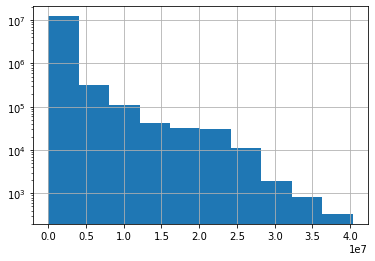

In [ ]:
datadf['delta'].hist(log=True)
datadf['delta'].describe()

Histogram is skewed heavily to left, with most words being encountered almost immediately after the previous time.  

Need to shift p_recall so next one is in previous record. save as next, then calculate the actual h for it. try different delta units

In [ ]:
# using days difference as delta instead
# plotting the calculated h(t) from the experimental p_recall(t) vs # of exposures and deltas
import math
import numpy as np
#datadf['p_recall'] = np.where(datadf['p_recall']==0,0.0001,datadf['p_recall']/(1.0001))
#datadf['logp_recall_2'] = datadf['p_recall'].apply(lambda x: math.log(x,2))
#datadf['calc_h'] = - datadf['delta']/datadf['logp_recall_2']
trace = datadf.loc[(datadf['user_id']=='u:bcH_')&\
           (datadf['lexeme_string']=='my/my<det><pos><sp>'),:].\
           sort_values(by='Datetime',ascending=True)
trace.head()
# also getting an idea of the sensitivity of p to h.

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt
193836,0.3333,1362092353,61015,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4766,2899,3,1,2013-02-28 22:59:13,0 days 16:56:55
196490,0.9999,1362092494,141,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4769,2900,2,2,2013-02-28 23:01:34,0 days 00:02:21
198265,0.9999,1362092593,100,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4771,2902,1,1,2013-02-28 23:03:13,0 days 00:01:40
202449,0.9999,1362092801,208,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4772,2903,1,1,2013-02-28 23:06:41,0 days 00:03:28
203745,0.9999,1362092866,65,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4773,2904,1,1,2013-02-28 23:07:46,0 days 00:01:05


In [ ]:

trace['p_recall_next'] = trace['p_recall'].shift(-1)
trace['delta_dt_next'] = trace['delta_dt'].shift(-1)
trace.head(15)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt,logpnext_recall_2,calc_h,p_recall_next,delta_dt_next
193836,0.333300,1362092353,61015,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4766,2899,3,1,2013-02-28 22:59:13,0 days 16:56:55,-0.000144,4.229449e+08,0.999900,0 days 00:02:21
196490,0.999900,1362092494,141,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4769,2900,2,2,2013-02-28 23:01:34,0 days 00:02:21,-0.000144,9.773864e+05,0.999900,0 days 00:01:40
198265,0.999900,1362092593,100,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4771,2902,1,1,2013-02-28 23:03:13,0 days 00:01:40,-0.000144,6.931818e+05,0.999900,0 days 00:03:28
202449,0.999900,1362092801,208,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4772,2903,1,1,2013-02-28 23:06:41,0 days 00:03:28,-0.000144,1.441818e+06,0.999900,0 days 00:01:05
203745,0.999900,1362092866,65,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4773,2904,1,1,2013-02-28 23:07:46,0 days 00:01:05,-2.000144,3.249766e+01,0.249975,0 days 00:01:38
205739,0.249975,1362092964,98,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4774,2905,4,1,2013-02-28 23:09:24,0 days 00:01:38,-1.000144,9.798586e+01,0.499950,0 days 00:01:46
208223,0.499950,1362093070,106,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4778,2906,2,1,2013-02-28 23:11:10,0 days 00:01:46,-13.287712,7.977295e+00,0.000100,0 days 00:02:48
211558,0.000100,1362093238,168,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4780,2907,1,0,2013-02-28 23:13:58,0 days 00:02:48,-13.287712,1.264326e+01,0.000100,0 days 00:01:31
213372,0.000100,1362093328,91,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4781,2907,1,0,2013-02-28 23:15:28,0 days 00:01:31,-1.000144,9.098687e+01,0.499950,0 days 00:01:37
215074,0.499950,1362093425,97,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4782,2907,2,1,2013-02-28 23:17:05,0 days 00:01:37,-13.287712,7.299977e+00,0.000100,0 days 00:01:02


In [ ]:
trace['logpnext_recall_2'] = trace['p_recall_next'].apply(lambda x: math.log(x,2))
trace['calc_h'] = - trace['delta_dt_next']/trace['logpnext_recall_2']


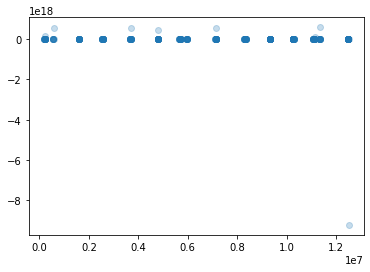

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(trace['calc_h'],'o',alpha=0.25)
plt.show()
plt.figure()

In [ ]:
trace['calc_h'].describe()

count                             351
mean      101 days 09:46:16.410693107
std       769 days 02:28:45.701714088
min         0 days 00:00:00.075257498
25%         0 days 00:00:08.353582379
50%         0 days 00:01:28.322126475
75%         0 days 00:03:33.636224877
max      6847 days 08:05:02.715648896
Name: calc_h, dtype: object

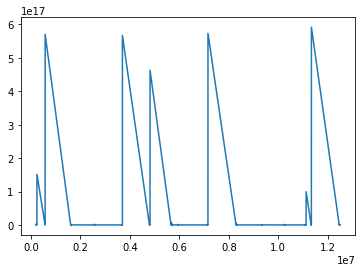

In [ ]:
plt.figure()
trace['calc_h'].plot()
#plt.ylim((0,10000000))


In [ ]:
trace['Date'] = trace['Datetime'].dt.date

In [ ]:
trace1 = trace.groupby('Date').agg(session_seen_ = pd.NamedAgg('session_seen','sum'),session_correct_ = pd.NamedAgg('session_correct','sum'))

In [ ]:
trace1['p_recall'] = trace1['session_correct_']/trace1['session_seen_']
trace1.head()

,session_seen_,session_correct_,p_recall
Date,,,
2013-02-28,51,21,0.411765
2013-03-01,14,3,0.214286
2013-03-02,45,22,0.488889
2013-03-03,63,27,0.428571
2013-03-04,53,22,0.415094


In [ ]:
#trace1 = trace1.reset_index()
trace1['next_date'] = trace1['Date'].shift(-1)
trace1['delta_'] = trace1['next_date'] - trace1['Date']

In [ ]:
trace1.head()

,Date,session_seen_,session_correct_,p_recall,next_date,delta_
0,2013-02-28,51,21,0.411765,2013-03-01,1 days
1,2013-03-01,14,3,0.214286,2013-03-02,1 days
2,2013-03-02,45,22,0.488889,2013-03-03,1 days
3,2013-03-03,63,27,0.428571,2013-03-04,1 days
4,2013-03-04,53,22,0.415094,2013-03-05,1 days


In [ ]:
trace1['p_recall'] = np.where(trace1['p_recall']==0,0.0001,trace1['p_recall']/1.0001)

In [ ]:
trace1['p_recall_next'] = trace1['p_recall'].shift(-1)
trace1['delta_next'] = trace1['delta_'].shift(-1)

In [ ]:
trace1

,Date,session_seen_,session_correct_,p_recall,next_date,delta_,p_recall_next,delta_next,log_pnext,calc_h
0,2013-02-28,51,21,0.411724,2013-03-01,1 days,0.214264,1 days,-2.251539,0 days 10:39:33.756324558
1,2013-03-01,14,3,0.214264,2013-03-02,1 days,0.488840,1 days,-1.029146,0 days 23:19:13.074666588
2,2013-03-02,45,22,0.488840,2013-03-03,1 days,0.428529,1 days,-1.217591,0 days 19:42:39.763276296
3,2013-03-03,63,27,0.428529,2013-03-04,1 days,0.415053,1 days,-1.251539,0 days 19:10:35.016955474
4,2013-03-04,53,22,0.415053,2013-03-05,1 days,0.374963,1 days,-1.434403,0 days 16:43:54.125690217
5,2013-03-05,72,27,0.374963,2013-03-06,1 days,0.350842,1 days,-1.514573,0 days 15:50:45.774710623
6,2013-03-06,57,20,0.350842,2013-03-07,1 days,0.461492,1 days,-1.120294,0 days 21:25:22.596367634
7,2013-03-07,65,30,0.461492,2013-03-08,1 days,0.382315,1 days,-1.395929,0 days 17:11:34.279747215
8,2013-03-08,102,39,0.382315,2013-03-09,1 days,0.387058,1 days,-1.358454,0 days 17:40:01.713307934
9,2013-03-09,62,24,0.387058,2013-03-10,1 days,0.379807,1 days,-1.395929,0 days 17:11:34.279747215


In [ ]:
trace1['log_pnext'] = trace1['p_recall_next'].apply(lambda x: math.log(np.around(x,2),2))

In [ ]:
trace1['calc_h'] = -trace1['delta_next']/trace1['log_pnext']

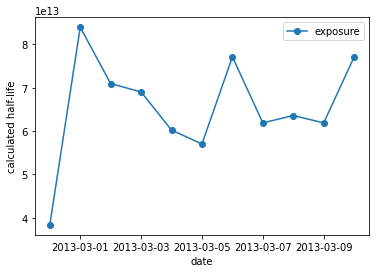

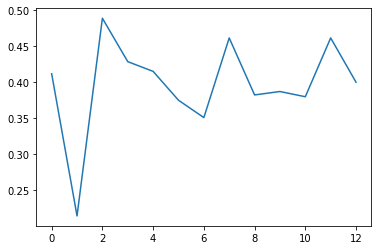

In [ ]:
plt.figure()
plt.plot(trace1['Date'][:-2],trace1['calc_h'][:-2],'o-')
plt.ylabel('calculated half-life')
plt.xlabel('date')
plt.legend(['exposure'])
plt.figure()
plt.plot(trace1['p_recall'])

Half-life is not montonically increasing here, or even non-decreasing. Is the assumption of how half-life increases really justified? Is this maybe because the style of questions changes? maybe transfer learning only happens after some more exposure. 

Try rolling windows after looking at some more curves?

In [ ]:
# how many reasonable long time traces do we have
timetraces = datadf.groupby(['user_id','lexeme_string'])['p_recall'].count()\
.sort_values(ascending=False)
timetraces.head(20)

user_id  lexeme_string                             
u:bcH_   my/my<det><pos><sp>                           352
         to/to<pr>                                     328
         not/not<adv>                                  316
         a/a<det><ind><sg>                             295
         is/be<vbser><pri><p3><sg>                     278
         we/prpers<prn><subj><p1><mf><pl>              260
u:bkiW   <*sf>/difference<n><*numb>                    231
u:bcH_   will/will<vaux><pres><@future>                230
         at/at<pr>                                     227
u:cpBu   is/be<vbser><pri><p3><sg>                     224
         a/a<det><ind><sg>                             216
u:bcH_   they/prpers<prn><subj><p3><mf><pl>            208
u:bkiW   personality/personality<n><sg>                208
u:bcH_   on/on<pr>                                     204
         are/be<vbser><pres>                           202
         have/have<vbhaver><pres><@present_perfect>    202
    

The purposr of plottin the histogram below is to estimate how many time traces are in the dataset with a certain length

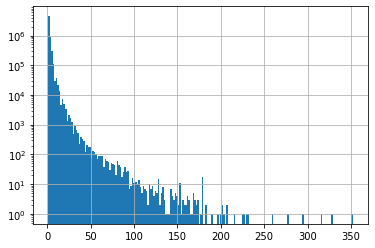

In [ ]:
timetraces.hist(log=True,bins=200)

In [ ]:
timetraces[timetraces>25].count()

9143

There are 9143 traces that are at least 25 records long. 

In [ ]:
timetraces[0]

352

We have a decent number of traceable learning for a number of words. >9000 with atleast 25 differnt sessions. let's trace one. 

In [ ]:
# let us check if it is indeed log normal
import scipy
from scipy import stats
plt.figure()
#scipy.stats.probplot(timetraces, dist='lognorm', fit=True, plot=plt, rvalue=False)
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
datadf.loc[(datadf['user_id']=='u:bcH_')&\
           (datadf['lexeme_string']=='my/my<det><pos><sp>'),:].\
           sort_values(by='Datetime',ascending=True)
  

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt
193836,0.333333,1362092353,61015,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4766,2899,3,1,2013-02-28 22:59:13,0 days 16:56:55
196490,1.000000,1362092494,141,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4769,2900,2,2,2013-02-28 23:01:34,0 days 00:02:21
198265,1.000000,1362092593,100,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4771,2902,1,1,2013-02-28 23:03:13,0 days 00:01:40
202449,1.000000,1362092801,208,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4772,2903,1,1,2013-02-28 23:06:41,0 days 00:03:28
203745,1.000000,1362092866,65,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4773,2904,1,1,2013-02-28 23:07:46,0 days 00:01:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500094,0.000000,1363065747,75,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5577,3225,1,0,2013-03-12 05:22:27,0 days 00:01:15
12501031,0.600000,1363065850,103,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5578,3225,5,3,2013-03-12 05:24:10,0 days 00:01:43
12502104,0.666667,1363065958,108,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5583,3228,3,2,2013-03-12 05:25:58,0 days 00:01:48
12503021,0.000000,1363066057,100,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5586,3230,3,0,2013-03-12 05:27:37,0 days 00:01:40


It looks like columns history seen, and history correct are computed as:
previous history seen + prev record session seen = 

Are there any traces for users encountering a word for the first time ever? (in duolingo)

In [ ]:
datadf.loc[datadf['history_seen']==1]

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt
18,0.0,1362082194,6032,u:FO,de,en,4fcb6bb8e44d7b618999721071862827,mädchen/mädchen<n><nt><sg><nom>,1,1,1,0,2013-02-28 20:09:54,0 days 01:40:32
19,1.0,1362082194,6032,u:FO,de,en,a6834806c43ea1be9eb3e4fdae6f98db,apfel/apfel<n><m><sg><nom>,1,1,1,1,2013-02-28 20:09:54,0 days 01:40:32
53,1.0,1362082297,6135,u:FO,de,en,dd34978165d17f7e729a2ef331a7600d,er/er<prn><p3><m><sg><nom>,1,1,1,1,2013-02-28 20:11:37,0 days 01:42:15
54,1.0,1362082297,6135,u:FO,de,en,495f763ef6027e020c53431484aa5ede,isst/essen<vblex><pri><p3><sg>,1,1,1,1,2013-02-28 20:11:37,0 days 01:42:15
56,0.0,1362082297,6135,u:FO,de,en,46b112cd07fdcc98db8670a5d71c613d,sie/sie<prn><p3><f><sg><nom>,1,1,1,0,2013-02-28 20:11:37,0 days 01:42:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854163,1.0,1363104894,441159,u:iWSo,it,en,8444bc37386d7ed98cb791fd5b7ea401,<*sf>/sapere<vblex><pri><*pers><*numb>,1,1,1,1,2013-03-12 16:14:54,5 days 02:32:39
12854164,1.0,1363104894,441159,u:iWSo,it,en,de46e1de082bb5af5570e57755a21f9b,<*sf>/trovare<vblex><pri><*pers><*numb>,1,1,1,1,2013-03-12 16:14:54,5 days 02:32:39
12854165,0.0,1363104894,441159,u:iWSo,it,en,b708ce1bd3baae7ed88fee2d81cd7174,<*sf>/vedere<vblex><pri><*pers><*numb>,1,1,1,0,2013-03-12 16:14:54,5 days 02:32:39
12854166,1.0,1363104894,441856,u:iWSo,it,en,105e0792b33a6062b5e7b5e60e8fe36c,<*sf>/volere<vbmod><pri><*pers><*numb>,1,1,1,1,2013-03-12 16:14:54,5 days 02:44:16


The minimum value history seen takes is 1. Not sure what that means. Will ask so-and-so. so there are no traces of the word being encountered for the first time? I guess you can use the delta to back calculate what the very first time was. 

In [ ]:
datadf.loc[(datadf['user_id']=='u:FO') & (datadf['lexeme_string']=='er/er<prn><p3><m><sg><nom>'),:]

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt
53,1.0,1362082297,6135,u:FO,de,en,dd34978165d17f7e729a2ef331a7600d,er/er<prn><p3><m><sg><nom>,1,1,1,1,2013-02-28 20:11:37,0 days 01:42:15
58,1.0,1362082362,65,u:FO,de,en,dd34978165d17f7e729a2ef331a7600d,er/er<prn><p3><m><sg><nom>,2,2,1,1,2013-02-28 20:12:42,0 days 00:01:05


Can we parse out what words were encountered in a single "session"?
basically group by user_id,and then within 15 minutes of each other?

First let's do it by day, then by hour, then calculate as 'morning','afternoon','evening'/ or should we cluster the timestamps for a day, and do a dbscan? is that overkill?

How does average p_recall change with time since last encountering the word?

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0, 0.5, 'p_recall')

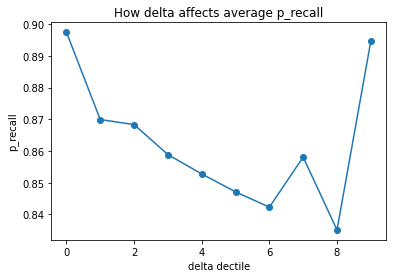

In [ ]:
datadf['cut_delta'] = pd.cut(datadf['delta'],10)
datadf['cut_delta'].head()
plt.figure()
plt.plot(datadf.groupby('cut_delta')['p_recall'].mean(),'o-')
plt.title('How delta affects average p_recall')
plt.xlabel('delta dectile')
plt.ylabel('p_recall')
#sns.barplot(x = 'cut_delta',y = 'p_recall',data = datadf)

How history_seen affects p_recall

(0.0, 2000.0)

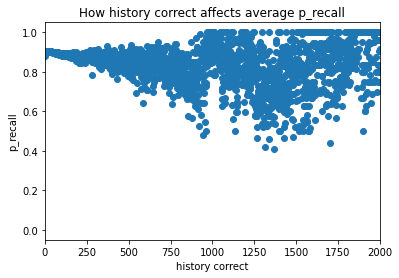

In [ ]:
plt.figure()
plt.plot(datadf.groupby('history_correct')['p_recall'].mean(),'o')
plt.title('How history correct affects average p_recall')
plt.xlabel('history correct')
plt.ylabel('p_recall')
plt.xlim((0,2000))

In [ ]:
datadf[['delta','history_seen','p_recall']].corr()

,delta,history_seen,p_recall
delta,1.000000,-0.030382,-0.030221
history_seen,-0.030382,1.000000,-0.022747
p_recall,-0.030221,-0.022747,1.000000


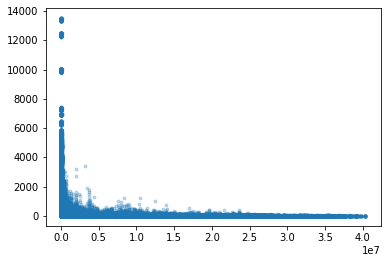

In [ ]:
# seaborn is a bad idea
# sns.pairplot(datadf[['delta','history_seen','p_recall']])
plt.plot(datadf['delta'],datadf['history_seen'],'.',alpha=0.25)

Its possible this slope is less steep than anticipated, because you encounter only words you've learned well at longer deltas (if the SRS is following a Leitner-ish model)

Let's see with what ease students who are native speakers learn a language. 
Let's look at average p_recall for groupings of students from each native to learning language

In [ ]:
# create column for coupling native to learning language
datadf['lang_tup'] = datadf.loc[:,['ui_language','learning_language']].apply(lambda x: (x[0],x[1]),axis=1)
datadf['lang_tup'].head()

0    (en, de)
1    (en, de)
2    (en, de)
3    (en, de)
4    (en, de)
Name: lang_tup, dtype: object

In [ ]:
datadf.groupby('lang_tup')['p_recall'].mean()

lang_tup
(en, de)    0.892786
(en, es)    0.898489
(en, fr)    0.882750
(en, it)    0.908592
(en, pt)    0.905512
(es, en)    0.896289
(it, en)    0.909596
(pt, en)    0.898728
Name: p_recall, dtype: float64

It looks like there is very little difference among the different student groups in their recall (on average). 

Does time of day of learning matter? (There is no timezone information here, is there/ Italian students could be sitting anywhere in the world and leanring English. - So we cannot really figure this one out.) We could make some assumptions, but the calculations would be quite annoying to do. and also assumes timestamps from possibly multiple servers are the exact same. Let's stick with date as our most granular unit. 

Let's get the words per date for each user.

In [ ]:
datadf['Date'] = datadf['Datetime'].dt.date

KeyError: ignored

In [ ]:
session_words = datadf.groupby(['user_id','Date'])['lexeme_string'].unique().reset_index()

In [ ]:
session_words.head()

,user_id,Date,lexeme_string
0,u:--N,2013-03-02,"[dem/das<det><def><nt><sg><dat>, im/in<pr>, ma..."
1,u:--U,2013-03-11,"[großes/groß<adj><pst><nt><sg><acc><mix>, klei..."
2,u:-3I,2013-03-05,"[buvez/boire<vblex><pri><p2><pl>, mangeons/man..."
3,u:-3n,2013-03-07,"[negra/negro<adj><f><sg>, nuevas/nuevo<adj><f>..."
4,u:-4V,2013-03-07,"[kaffee/kaffee<n><m><sg><acc>, fisch/fisch<n><..."


In [ ]:
num_sessions = session_words.groupby('user_id')['Date'].unique()

In [ ]:
num_sessions = pd.DataFrame(num_sessions)
num_sessions['num'] = num_sessions['Date'].apply(lambda x: len(x))

In [ ]:
num_sessions.sort_values(by='num',ascending=False).head()

,Date,num
user_id,,
u:db7q,"[2013-02-28, 2013-03-01, 2013-03-02, 2013-03-0...",13
u:h82e,"[2013-02-28, 2013-03-01, 2013-03-02, 2013-03-0...",13
u:fzXO,"[2013-02-28, 2013-03-01, 2013-03-02, 2013-03-0...",13
u:bcH_,"[2013-02-28, 2013-03-01, 2013-03-02, 2013-03-0...",13
u:fP8x,"[2013-02-28, 2013-03-01, 2013-03-02, 2013-03-0...",13


In [ ]:
#how would we divide train and test data for time series? how would we cross validate?


Let's look at how p_recall changes in real time for some traces.

In [ ]:
trace = datadf.loc[(datadf['user_id']=='u:bcH_')&\
           (datadf['lexeme_string']=='my/my<det><pos><sp>'),:].\
           sort_values(by='Datetime',ascending=True)
trace.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt,cut_delta,lang_tup,Date
193836,0.333333,1362092353,61015,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4766,2899,3,1,2013-02-28 22:59:13,0 days 16:56:55,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
196490,1.000000,1362092494,141,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4769,2900,2,2,2013-02-28 23:01:34,0 days 00:02:21,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
198265,1.000000,1362092593,100,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4771,2902,1,1,2013-02-28 23:03:13,0 days 00:01:40,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
202449,1.000000,1362092801,208,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4772,2903,1,1,2013-02-28 23:06:41,0 days 00:03:28,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
203745,1.000000,1362092866,65,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,4773,2904,1,1,2013-02-28 23:07:46,0 days 00:01:05,"(-40327.361, 4032837.1]","(es, en)",2013-02-28


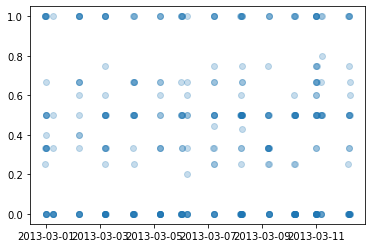

In [ ]:
plt.plot(trace['Datetime'],trace['p_recall'],'o',alpha=0.25)

There are multiple p_values for each date for the same word and same user. we should look at the first p-recall for each day. as well as the average over the day

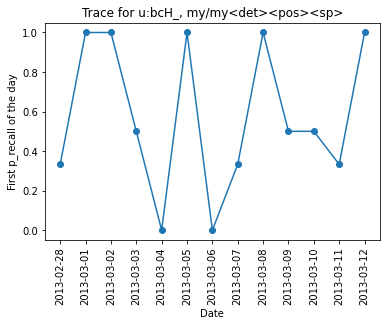

In [ ]:
trace_first = trace.groupby('Date')['p_recall'].first()
plt.plot(trace_first,'o-')
plt.xticks(trace_first.index,rotation = 90)
plt.ylabel('First p_recall of the day')
plt.xlabel('Date')
plt.title("Trace for u:bcH_, my/my<det><pos><sp>")
plt.show()

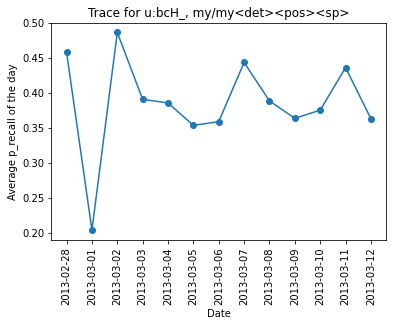

In [ ]:
trace_mean = trace.groupby('Date')['p_recall'].mean()
plt.plot(trace_mean,'o-')
plt.xticks(trace_first.index,rotation = 90)
plt.ylabel('Average p_recall of the day')
plt.xlabel('Date')
plt.title("Trace for u:bcH_, my/my<det><pos><sp>")
plt.show()

Can we look at all the traces for one student grouping for one word? Do we care about exact deltas or do we need only day differences?

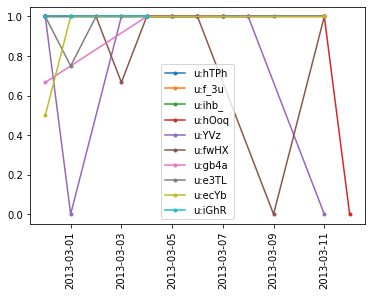

In [ ]:
#lang_tup = ('en','sp')
lexeme_string = "my/my<det><pos><sp>"

user_id_list = datadf.loc[(datadf['lexeme_string']==lexeme_string) , 'user_id'].unique()

plt.figure()

num_students = 1

for user_id in user_id_list:
  trace = datadf.loc[(datadf['user_id']==user_id)&\
           (datadf['lexeme_string']==lexeme_string),:].\
           sort_values(by='Datetime',ascending=True)
  if trace.shape[0]>1:
    trace_first = trace.groupby('Date')['p_recall'].first()
    plt.plot(trace_first,'.-',label = user_id)
    plt.xticks(rotation = 90)
    num_students += 1
  if num_students > 10:
    break
plt.legend()
plt.show()

In [ ]:
traces = pd.DataFrame(traces)
traces = traces.reset_index()
traces.head()

NameError: ignored

In [ ]:
# Sessions previously seen and answered correctly tallies with the previous row's values. 

# with what confidence can we predict the proportion of times a student will recall the 
# correct answer for a given word, and time for a trace that already exists?

# can we predict what the p_recall would be for a time trace that does not exist, given 3 or 4 rows of previous? 
# would these have to be consecutive?

# should we use more than just the previous session as features?

# might overpracticing lead to disengagement? - how to define disengagement?
# might underpracticint lead to overwhelm?

# could we predict based on language learning, ui language, performance on other words, what would the performance on a new word look like?
# at different times? as in would they find that word hard or easy?

# can we predict when student should encounter word again to maximize retention?

# what are the state of the art approaches?

# can we cluster similar students by background? 

# can we see something like - if they have an easy time with this word, they also havw an easy time with this other word?
## can we see if TFIDF and common roots with a word encountered before matters?
# might the word vector matter? 
# might time or day of week matter. would need time zone information
# might priming impact things - as in encountering two words in the same session again has a helping effect?
# encountering late or early in a session?
# what is different about engaged vs not engaged students - when does it drop off

# does performance impact engagement, and return rates?


In [ ]:
# how many of these traces look at the first time a word is encountered?

# should what language you are native at change how the duolingo lesson works?

# can you recommend words for the next session based on current performance?

In [ ]:
# lets set up a simple linear regression model
# with just delta, history_seen, history_correct as a fraction, and try fitting it . let's see what happens. 
X = datadf[['delta','history_seen','history_correct','session_seen']]
X['history_correct'] = X['history_correct']/X['history_seen']
X.head()

In [ ]:
y = datadf['p_recall']

In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import norm #used for plotting
import statsmodels.api as sm

In [ ]:
def colinearity_check(X,threshold_abs_corr= 0.25):
    """
    To check if there is colinearity in parameters before modeling:
    1. Computes correlation matrix for parameters, and displays as a heatmap.
    2. Displays correlation coefficients in order of strength
    3. Plots the strongest positive and negative correlations
    =========================================================
    Requires libraries:
    seasborn as sns
    matplotlib.pyplot as plt
    pandas as pd
    =============================================================
    Arguments: 
    X: pandas dataframe of parameters
    threshold_abs_corr: the minimum absolute value of correlation 
                        coefficient, above which it is considered 
                        a strong correlation, default value: 0.25
    =============================================================
    Returns:
    None
    """
    
    corr_matrix = X.corr()
    scale = X.shape[1]*0.9
    plt.figure(figsize=(scale,scale))
    plt.title("Correlation matrix of parameters")
    sns.heatmap(corr_matrix, vmin=-1, vmax =1, center = 0, mask = np.triu(corr_matrix),cmap = "coolwarm",annot=True)
    plt.show()
    
    # order correlations by strength.
    # get correlation matrix as stacked dataframe
    corr_matrix = corr_matrix.stack().reset_index()
    corr_matrix.columns = ['Param1','Param2','CorrCoef']
    
    # drop correlations of parameters with themselves
    corr_matrix = corr_matrix.drop(corr_matrix[corr_matrix['Param1']==corr_matrix['Param2']].index)

    # drop duplicates (param1,param2) or (param2,param1)
    corr_matrix['coupled'] = corr_matrix[['Param1','Param2']].apply(lambda x: frozenset([x[0],x[1]]),axis=1)
    corr_matrix = corr_matrix.drop_duplicates(subset='coupled')
    corr_matrix = corr_matrix.drop('coupled',axis=1)
    
    # get strongest correlations above a threshold. 
    corr_matrix['AbsCorrCoef'] = abs(corr_matrix['CorrCoef'])
    strong_corr = corr_matrix.loc[corr_matrix['AbsCorrCoef']>=threshold_abs_corr,:]
    #strong_subset = set(corr_matrix['Param1']).union(set(corr_matrix['Param2']))
    totalplot_num = strong_corr.shape[0]
    if totalplot_num%3==0:
        fig_rows = totalplot_num/3
    else:
        fig_rows = int(totalplot_num/3)+1
    
    strong_corr = strong_corr.sort_values(by = 'AbsCorrCoef',ascending=False)
    # Generate plots for strong correlations
    display(HTML("Pair plots"))
    print(f"(|Correlation coefficient| > {threshold_abs_corr})")
    plt.subplots(int(fig_rows),3,figsize=(15,fig_rows*4.5))
    plot_num = 1
    for i,row in strong_corr.iterrows():
        
        plt.subplot(int(fig_rows),3, plot_num)

        plt.title(row['Param2']+' vs '+row['Param1']+', Corr='+str(np.round(row['CorrCoef'],2)))
        plt.xlabel(row['Param1'])
        plt.ylabel(row['Param2'])
        if X[row['Param1']].dtype==int or X[row['Param1']].dtype==bool: # check if column is discrete numeric
            if row['Param1'] in ['Year','Week','Month']: # if time, plot a line plot
                sns.lineplot(x = row['Param1'], y= row['Param2'],data=X)
            else:
                sns.boxplot(x = row['Param1'],y= row['Param2'],data=X) # if discrete numeric, plot a boxplot
        else:
            plt.plot(X[row['Param1']],X[row['Param2']],'o',alpha = 0.05) # if continuous numeric, plot a scatter plot
        plot_num +=1

    plt.tight_layout()
    plt.show()

def run_OLS_model(X,y):
  """
  Runs an ordinary least square model for a given X and y

  Warning: does not check for data compatibility exhaustively
  =====================================================
  Requires libraries:
  pandas as pd
  stats.scipy as stats
  statsmodels.api as sm
  =====================================================
  Arguments:
  X: the predictor variables (not including constant), matrix of numeric variables
  y: target variable, vector of numeric variable
  =====================================================
  Returns:
  myreg1_results: statsmodels OLS model regression results wrapper object (object returned by OLS model fit method)
  """
  assert X.shape[0]==y.shape[0], "Dimensions for X and y do not match, rows should be same"
  # adding constant to X
  X_withc = sm.add_constant(X)

  # 1. Instantiate Model
  myreg1 = sm.OLS(y, X_withc)

  # 2. Fit Model (this returns a seperate object with the parameters)
  myreg1_results = myreg1.fit()

  # Display at the summary
  myreg1_results.summary()
  return myreg1_results    
    

def evaluate_LR_model(mylogreg_results,X):
    """
    Compute the accuracy of a logistic regression model
    Return the accuracy at 0.5,
    Plot accuracy as a function of boundary condition
    Return best accuracy and its corresponding boundary condition
    ==============================================
    Required libraries:
    matplotlib.pyplot as plt
    pandas as pd
    stats.scipy as stats
    statsmodels.api as sm
    ===============================================
    Arguments:
    mylogreg_results: statsmodels logistic regression fit object
    X : the parameter dataset
    ===============================================
    Returns:
    accuracy: Accuracy at boundary condition 0.5
    max_accuracy : max accuracy obtained
    best_bc : boundary condition corresponding to maximum accuracy
    """
    
    # get probabilities (y_predicted)
    probs = mylogreg_results.predict(sm.add_constant(X))
    
    # compute accuracy for a range of boundary conditions, save to dict
    bc_list = np.arange(0.1,1,step=0.1)
    predictions = dict()
    accuracy = dict()
    total_preds = len(probs)
    accuracy = dict()
    for bc in bc_list:
        predictions[bc] = np.where(probs > bc,1,0)
        accuracy[bc] = (y==predictions[bc]).sum()/total_preds*100
    
    # plot line plot of accuracy vs boundary condition
    plt.figure()
    plt.title("Accuracy vs boundary condition")
    plt.plot(accuracy.keys(),accuracy.values())
    plt.show()

    # get max accuracy achieved, and the corresponding boundary condition
    max_accuracy = max(list(accuracy.values()))
    for key in accuracy:
        if accuracy[key] == max_accuracy:
            best_bc = key
            break

    # print results and return
    print(f"Accuracy at boundary_condition=0.5 = {accuracy[0.5]}%")
    print(f"Highest accuracy is at boundary_condition={best_bc} = {max_accuracy}%")
    
    return accuracy[0.5],max_accuracy, best_bc


def OLS_residual_analysis(myreg_results):
  """ 
  Takes in an OLS model and does the following residual analyses for model evaluation:
  1. Shapiro Wilk Test for normality
  2. Histogram of residuals - checking for normality
  3. Q-Q plot of residual distribution
  4. Residuals vs fitted values scatter plot
  ===============================================================================
  Arguments:
  myreg_results: statsmodels OLS model regression results wrapper object (object returned by OLS model fit method)
  ===============================================================================
  Returns:
  none.(plots are displayed from within function)
  ===============================================================================
  Requires libraries:
  import matplotlib.pyplot as plt
  import pandas as pd
  import numpy as np
  import scipy.stats as stats
  """
  print()
  print("============================================")
  print("Residual Analysis of OLS model: ")
  print("Testing the assumption that model residuals are normally disitributed:")
  print("1. Shapiro-Wilk Test for Normality")
  print("Null Hypothesis H0 : The residuals are normally distributed")
  print("Alternate Hypothesis Ha: The residuals are not normally distributed")
  print()
  print("Shapiro-Wilk Test Results:")

  # calculating the shapiro test statisic and its p-value
  SWteststat, SWpvalue = stats.shapiro(myreg_results.resid)
  print(f"Test statistic: {SWteststat}")
  print(f"p-value: {SWpvalue}")
  if SWpvalue < 0.05:
    print("Since the p-value is less than 0.05, there is a statistically significant chance of the residuals not being normally distributed.")
  else:
    print("Since the p-value is more than 0.05, we do not reject the null hypothesis that the residuals are normally distributed.")
  print()
  print("============================================")
  print()
  
  
  # getting histogram of residuals
  print("2. Histogram of residuals is below.")
  plt.subplots(1,3,figsize=(15,5))
  plt.subplot(1,3,1)
  plt.hist(myreg_results.resid)
  plt.xlabel("Binned Residuals")
  plt.ylabel("Frequency counts")
  plt.axvline(myreg_results.resid.mean(),color='black',linewidth = 3)
  plt.axvline(myreg_results.resid.median(),color='red',linewidth = 3)
  plt.title("Distribution of residuals")
  plt.legend(['Mean','Median','Counts'])
  

  # getting skewness results
  skew = myreg_results.resid.skew()
  print(F"Skew of distribution is {skew}")
  if skew>1:
    print("Distribution is skewed slightly to the right")
  elif skew > 3:
    print("Distribution is right skewed")
  elif skew<-1:
    print("Distribution is skewed slightly to the left")
  elif skew <-3:
    print("Distribution is left skewed")
  else:
    print("Distribution is not heavily skewed")

  print()
  print("============================================")
  print()

  # getting Q-Q plot test for normality of residuals
  print("3. Q-Q plot is below")
  plt.subplot(1,3,2)
  #plt.figure()
  plt.title("Q-Q plot of residuals")
  stats.probplot(myreg_results.resid,dist="norm", plot = plt)
  plt.legend(['Residuals','Perfect normal trend line'])
  #plt.show()
  print()
  print("============================================")
  print()

  # getting scatter plot of model residual variance with fitted values 
  print("4. Scatter plot of residuals vs model fitted values is below.")
  plt.subplot(1,3,3)
  plt.plot(myreg_results.fittedvalues,myreg_results.resid,'o',alpha=0.25)
  plt.title("Model residuals vs model fitted values")
  plt.xlabel("Model fitted values (y_predicted)")
  plt.ylabel("Model residuals (y_real-y_predicted)")
  
  plt.tight_layout()
  plt.show()


def one_way_anova_summary(cat_v, num_v, df, exclude = []):
  """
  Gives a summary of one-way ANOVA test results for a categorical and numerical variable in a pandas dataframe,
  including hypotheses, values, and a boxplot. 
  ===========================================
  Requires libraries: 

  matplotlib.pyplot as plt
  seaborn as sns
  stats from scipy
  pandas as pd
  ===========================================
  Arguments:

  cat_v: categorical variable name in dataframe, string type
  num_v: numerical variable name in dataframe, string type
  df: dataframe of interest
  exclude : categorical values to exclude, list type, default is empty list
  ===========================================
  Returns:
  statval: test statistic value for one-way ANOVA test
  pval: p-value for one-way ANOVA test with categorical and numerical variable in dataframe
  pltobj : matplotlib plot object showing a boxplot of the groups
  ============================================
  """
  assert type(cat_v)==str, "Categorical variable name has to be a string"
  assert cat_v in df.columns, "Categorical variable not found in dataframe"
  assert type(num_v)==str, "Numerical variable name has to be a string"
  assert num_v in df.columns, "Numerical variable not found in dataframe"
  assert type(exclude)==list, "Exclude argument has to be a list"
  
  catv_anova = dict()
  catv_vals = df[cat_v].unique()


  for val in catv_vals:
    if val not in exclude:
      catv_anova[val] = df.loc[df[cat_v]==val,num_v]
  
  catv_args = tuple([item[1] for item in catv_anova.items()])

  statval,pval = stats.f_oneway(*catv_args)

  print(f"{cat_v} & {num_v} one-way ANOVA Test:")
  print("="*30)
  print()
  print("Groups tested:")
  print("="*30)
  print(list(catv_anova.keys()))
  print()
  print(f"Null hypothesis H0: The mean value of {num_v} is the same across the groups in {cat_v}")
  print(f"Alternate hypothesis Ha: The mean value of {num_v} is different for at least one group in {cat_v}")
  print("="*30)
  print()
  print(f"{cat_v} & {num_v} one-way ANOVA Results:")
  print(f"test_statistic = {statval}, p-value = {pval}")
  print()

  if pval<0.05:
    print(f"Based on the p-value of {pval}, we can reject the null hypothesis that the mean {num_v} is the same for all groups.")
    print(f"At least one group in {cat_v} has a different mean value of {num_v}")
  else:
    print(f"Based on the p-value of {pval}, we cannot reject the null hypothesis that the mean {num_v} is the same for all groups.")

  
  pltobj = sns.boxplot(x=num_v, y=cat_v, data=df.loc[~df[cat_v].isin(exclude)])
  try:
    pltobj.title(num_v+" by "+cat_v)
  except:
    pltobj.set_title(num_v+" by "+cat_v) 

  
  return statval,pval,pltobj


def interpret_OLS_results(myreg1_results):
  """ 
  Interprets the results of an ordinary least squares model:
  1. points out the parameters with a p-value > 0.05 
  2. displays statistically significant coefficients in descending order in table and bar chart
  =========================================================
  Requires libraries:
  matplotlib.pyplot as plt
  pandas as pd
  scipy.stats as stats
  =========================================================
  Arguments:
  myreg1_results: statsmodels OLS model regression results wrapper object (object returned by OLS model fit method)
  =========================================================
  Returns:
  None (plots displayed from within function)
  """
  
  # get coefficients and pvalues into dataframe
  modeldf = pd.DataFrame(data = {'coefficients':myreg1_results.params,'pvalues':myreg1_results.pvalues})
  modeldf = modeldf.reset_index()

  # get coefficients with p-values >0.05 and display
  highp = modeldf[modeldf['pvalues']>=0.0500]
  if highp.shape[0]>0:
    print()
    print("Consider removing these predictors with pvalues > 0.05. We cannot reject the null hypothesis that the population coefficient values are zero.")
    display(highp.loc[:,['index','pvalues']])
  else:
    print("No coefficients with pvalues > 0.05")

  # display the coefficients table in descending order  
  print("\n")
  print("The below predictors had statistically significant coefficients. We can reject the null hypothesis that the population coefficients of these parameters are zero.")
  print("We can accept that the population coefficient values are non-zero")
  display(modeldf.loc[modeldf['pvalues']<0.0500,['index','coefficients','pvalues']].sort_values(by = 'coefficients',ascending=False))

  # plot bar chart showing scale of coefficients for easy interpreting
  plt.figure()
  #plt.figure(figsize = (7,min(int(modeldf.shape[0]*0.25),3)))
  sns.barplot(x = 'coefficients',y='index',data=modeldf.sort_values(by='coefficients',ascending=False), color='blue')
  plt.title("Model parameter coefficients")
  plt.xlabel('Coefficients')
  plt.ylabel('Parameters')
  plt.show()

def run_LR_model(X,y):
    """ 
    Run logistic regression model from statsmodels
    
    Warning: does not check for data compatibility exhaustively
    =====================================================
    Requires libraries:
    pandas as pd
    stats.scipy as stats
    statsmodels.api as sm
    =====================================================
    Arguments:
    X: the predictor variables (not including constant), matrix of numeric variables
    y: target variable, vector of numeric variable
    =====================================================
    Returns:
    logreg_results: statsmodels logit model regression results wrapper object (object returned by logit model fit method)
    """
    # 0. add constant
    X_withc = sm.add_constant(X)
    # 1. Instantiate model
    logreg= sm.Logit(y,X_withc)
    # 2. Fit model
    logreg_results = logreg.fit()
    # Look at summary
    logreg_results.summary()
    
    return logreg_results




  

In [ ]:
import scipy.stats as stats
from scipy.stats import norm 
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
modeldict = dict()
modeldict['M0'] = run_OLS_model(X,y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
modeldict['M0'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               p_recall   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.1216
Date:                Mon, 23 May 2022   Prob (F-statistic):              0.886
Time:                        05:48:52   Log-Likelihood:                -17.073
No. Observations:                  31   AIC:                             40.15
Df Residuals:                      28   BIC:                             44.45
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7351      0.704      1.044      0.306      -0.708       2.178
history_p     -0.0528      0.784     -0.067      0.947      -1.659       1.554
inv_delta     -5.4030     10.958     -0.493      0.626     -27.850      17.044
==============================================================================
Omnibus:                        7.998   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                4.917
Skew:                          -0.800   Prob(JB):                       0.0856
Kurtosis:                       1.884   Cond. No.                         185.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Consider removing these predictors with pvalues > 0.05. We cannot reject the null hypothesis that the population coefficient values are zero.


,index,pvalues
0,const,0.305529
1,history_p,0.946763
2,inv_delta,0.625815




The below predictors had statistically significant coefficients. We can reject the null hypothesis that the population coefficients of these parameters are zero.
We can accept that the population coefficient values are non-zero


,index,coefficients,pvalues


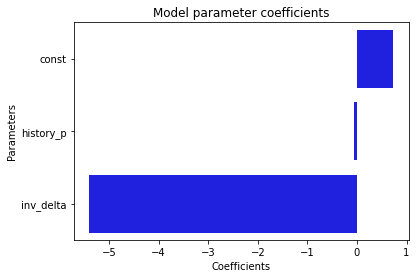

In [ ]:
interpret_OLS_results(modeldict['M0'])

In [ ]:
plt.plot(X['session_seen'],y,'.',alpha=0.25)

Yikes. What about separating out for each user?

In [ ]:
usersp = datadf.loc[datadf['user_id']=='u:FO']
usersp['history_p'] = usersp['history_correct']/usersp['history_seen']
usersp['inv_delta'] = 1/usersp['delta']
usersp['p_delta'] = usersp['history_p']*usersp['inv_delta']
X = usersp[['p_delta']]
y = usersp['p_recall']
print(usersp.shape[0])
run_OLS_model(X,y).summary()

31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               p_recall   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.2043
Date:                Mon, 23 May 2022   Prob (F-statistic):              0.655
Time:                        06:09:07   Log-Likelihood:                -17.099
No. Observations:                  31   AIC:                             38.20
Df Residuals:                      29   BIC:                             41.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6867      0.087      7.865      0.000       0.508       0.865
p_delta       -5.7759     12.779     -0.452      0.655     -31.913      20.361
==============================================================================
Omnibus:                        8.044   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                4.910
Skew:                          -0.798   Prob(JB):                       0.0859
Kurtosis:                       1.879   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All student traces for one particular word, looking at history correct, delta, history seen to predict p_recall. 

In [ ]:
wordsp = datadf.loc[datadf['lexeme_string']=='no/no<adv>']
X = wordsp[['history_seen','delta','history_correct']]
X['history_correct'] = X['history_correct']/X['history_seen']
y = wordsp['p_recall']
print(wordsp.shape[0])
run_OLS_model(X,y).summary()

history_correct/history_seen & 1/delta as the predictors?

Get columns of previous session's p_recall for each trace. 

In [ ]:
trace.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt,cut_delta,lang_tup,Date
2436,1.0,1362082652,319,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,8,8,1,1,2013-02-28 20:17:32,0 days 00:05:19,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
11937,1.0,1362083170,518,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,9,9,1,1,2013-02-28 20:26:10,0 days 00:08:38,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
862817,1.0,1362152282,69112,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,10,10,1,1,2013-03-01 15:38:02,0 days 19:11:52,"(-40327.361, 4032837.1]","(es, en)",2013-03-01
4032636,1.0,1362414439,262157,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,11,11,2,2,2013-03-04 16:27:19,3 days 00:49:17,"(-40327.361, 4032837.1]","(es, en)",2013-03-04


In [ ]:
# previous session p_recalls?
trace


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,Datetime,delta_dt,cut_delta,lang_tup,Date
2436,1.0,1362082652,319,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,8,8,1,1,2013-02-28 20:17:32,0 days 00:05:19,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
11937,1.0,1362083170,518,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,9,9,1,1,2013-02-28 20:26:10,0 days 00:08:38,"(-40327.361, 4032837.1]","(es, en)",2013-02-28
862817,1.0,1362152282,69112,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,10,10,1,1,2013-03-01 15:38:02,0 days 19:11:52,"(-40327.361, 4032837.1]","(es, en)",2013-03-01
4032636,1.0,1362414439,262157,u:iGhR,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,11,11,2,2,2013-03-04 16:27:19,3 days 00:49:17,"(-40327.361, 4032837.1]","(es, en)",2013-03-04


In [ ]:
datadf['delta'].hist()

NameError: ignored

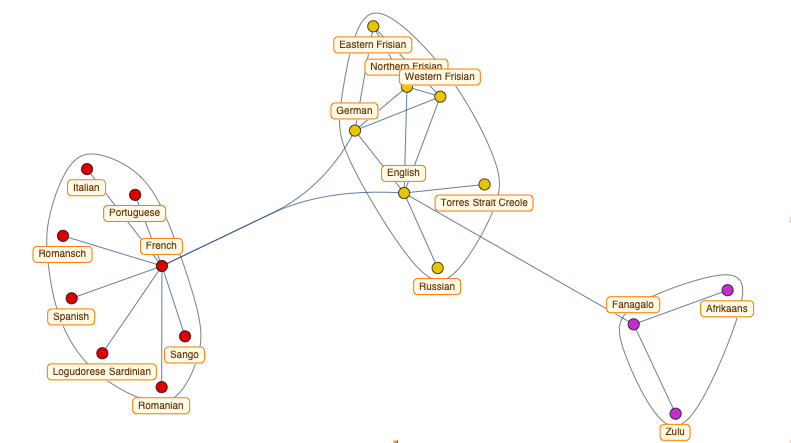